# train

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from rl_env_inc import TrajComp
from rl_brain import PolicyGradient
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def run_online(env, RL, ratio, elist): # Validation
    eva = []
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            action = RL.pro_choose_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return sum(eva)/len(eva)
        
def run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio): #Training
    check = 999999
    tra_av_errs = []#放的是每50回合训练集上的平均误差
    val_av_errs = []#放的是每50回合验证集上的平均误差
    train_ep_errs = []
    for r in range(Round):
        env.shuffle()
        show_time = 50
        episode = 0
        for i in range(0, traj_amount, show_time):
            start_t = time.time()
            for _ in tqdm(range(show_time), desc="[{}/{}]".format(min(i+show_time,traj_amount),traj_amount),ncols=100):
                buffer_size = int(ratio*len(env.ori_traj_set[episode]))
                # extreme cases
                if buffer_size < 3:
                    episode += 1
                    continue
                steps, state = env.reset(episode, buffer_size)#初始化状态值，返回轨迹点数和有序列表前k个状态值
                for index in range(buffer_size, steps):#从第一次缓存外第一个点遍历到最后一个点
                    if index == steps - 1:#如果已经是轨迹最后一个点
                        done = True
                    else:
                        done = False
                    action = RL.pro_choose_action(state)#状态输出到神经网络输出动作的概率分布，按概率采样一个动作
                    new_state, reward = env.step(episode, action, index, done, 'T') #'T' means Training, and 'V' means Validation                   
                    RL.store_transition(state, action, reward)
                    if done:
                        RL.learn()#回合结束开始策略梯度算法学习参数
                        break
                    state = new_state
                train_e = env.output(episode, 'T') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
                episode += 1
            train_ep_errs.append(train_e)
            val_av_err1 = run_online(env, RL, ratio, [i for i in range(traj_amount, traj_amount + valid_amount)])
            val_av_err2 = run_online(env, RL, ratio, [i for i in range(traj_amount, traj_amount + valid_amount)])
            val_av_err = ( val_av_err1 + val_av_err2 ) / 2
            val_av_errs.append(val_av_err)
            tra_av_err = sum(train_ep_errs[-10:])/len(train_ep_errs[-10:])
            tra_av_errs.append(tra_av_err)
            print('round {} episode {}: Training error: {}, Validation error: {}'.format(r, episode, tra_av_err, val_av_err))
            if val_av_err < check:
                check = val_av_err
                RL.save('./save/'+ str(val_av_err) + '_ratio_' + str(ratio) + '_' + env.label + '/trained_model.ckpt')
                print('Save model with error {}'.format(val_av_err))
            print('==>current best model is {} with ratio {}'.format(check, ratio))
            print('It costs {}s'.format(time.time()-start_t))
    return tra_av_errs, val_av_errs

def train(traj_amount, valid_amount, Round, show_time, ratio, a_size, s_size, learning_rate, label):
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_train_data(traj_path, traj_amount, valid_amount, cut=True)
    env.set_error_type(label)
    RL = PolicyGradient(env.n_features, env.n_actions, learning_rate)
    start = time.time()
    tra_av_errs, val_av_errs = run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio)
    print("Training elapsed time = %s", float(time.time() - start))
    with open('errors_records.txt', 'a') as f:
        f.write('\nTraining errors and validation errors (' + label + ')\n')
        for i in range(len(tra_av_errs)):
            f.write(str(tra_av_errs[i])+' ')
        f.write('\n')
        for i in range(len(val_av_errs)):
            f.write(str(val_av_errs[i])+' ')
    plt.figure()
    plt.title("Average errors of training and validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, tra_av_errs, "r", label="training" )
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.figure()
    plt.title("Average errors of validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.show()


======loading train data======
It cost 65.6460485458374s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.10it/s]


Training error: 55.07285134351334, Validation error: 36.544118965523545

Save model at round 0 episode 50 with error 36.544118965523545
==>current best model is 36.544118965523545 with ratio 0.1
It costs 149.41583275794983s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


Training error: 31.95694896629777, Validation error: 37.663777464979425
Save model at round 0 episode 100 with error 37.663777464979425
==>current best model is 36.544118965523545 with ratio 0.1
It costs 164.92068338394165s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 29.53760309560645, Validation error: 34.97825249889925
Save model at round 0 episode 150 with error 34.97825249889925
==>current best model is 34.97825249889925 with ratio 0.1
It costs 157.695650100708s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


Training error: 33.58588564750404, Validation error: 36.20500557021408
Save model at round 0 episode 200 with error 36.20500557021408
==>current best model is 34.97825249889925 with ratio 0.1
It costs 164.3507776260376s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


Training error: 39.62490387912265, Validation error: 35.97228361901633
Save model at round 0 episode 250 with error 35.97228361901633
==>current best model is 34.97825249889925 with ratio 0.1
It costs 162.96465921401978s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 33.10012461095757, Validation error: 34.0410522289584
Save model at round 0 episode 300 with error 34.0410522289584
==>current best model is 34.0410522289584 with ratio 0.1
It costs 160.6731560230255s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 32.64190752081578, Validation error: 35.59797744031362
Save model at round 0 episode 350 with error 35.59797744031362
==>current best model is 34.0410522289584 with ratio 0.1
It costs 158.2836401462555s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 49.50658835603943, Validation error: 35.543141770529694
Save model at round 0 episode 400 with error 35.543141770529694
==>current best model is 34.0410522289584 with ratio 0.1
It costs 156.10273504257202s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 59.988941900510596, Validation error: 34.828878143197684
Save model at round 0 episode 450 with error 34.828878143197684
==>current best model is 34.0410522289584 with ratio 0.1
It costs 156.76902794837952s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 34.100939871516154, Validation error: 32.71302125338894
Save model at round 0 episode 500 with error 32.71302125338894
==>current best model is 32.71302125338894 with ratio 0.1
It costs 154.9168221950531s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 29.620134150517885, Validation error: 33.9783540760311
Save model at round 1 episode 50 with error 33.9783540760311
==>current best model is 32.71302125338894 with ratio 0.1
It costs 154.75054144859314s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 34.747863402774826, Validation error: 33.12546178524144
Save model at round 1 episode 100 with error 33.12546178524144
==>current best model is 32.71302125338894 with ratio 0.1
It costs 155.23937582969666s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


Training error: 37.71639510994437, Validation error: 33.41244991381151
Save model at round 1 episode 150 with error 33.41244991381151
==>current best model is 32.71302125338894 with ratio 0.1
It costs 152.06755328178406s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 24.88201636839436, Validation error: 33.243459906308324
Save model at round 1 episode 200 with error 33.243459906308324
==>current best model is 32.71302125338894 with ratio 0.1
It costs 154.246160030365s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 31.920142590356107, Validation error: 32.52320726565185
Save model at round 1 episode 250 with error 32.52320726565185
==>current best model is 32.52320726565185 with ratio 0.1
It costs 167.06800627708435s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 25.165316522214134, Validation error: 32.22597046635939
Save model at round 1 episode 300 with error 32.22597046635939
==>current best model is 32.22597046635939 with ratio 0.1
It costs 155.9409375190735s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it]


Training error: 41.08031507830034, Validation error: 32.562786450316636
Save model at round 1 episode 350 with error 32.562786450316636
==>current best model is 32.22597046635939 with ratio 0.1
It costs 150.85799312591553s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 36.78358640662985, Validation error: 31.648789229526496
Save model at round 1 episode 400 with error 31.648789229526496
==>current best model is 31.648789229526496 with ratio 0.1
It costs 153.77063965797424s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 33.26820589820684, Validation error: 31.83291219618583
Save model at round 1 episode 450 with error 31.83291219618583
==>current best model is 31.648789229526496 with ratio 0.1
It costs 169.9268820285797s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


Training error: 67.93003409787258, Validation error: 31.0639062015643
Save model at round 1 episode 500 with error 31.0639062015643
==>current best model is 31.0639062015643 with ratio 0.1
It costs 163.385014295578s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


Training error: 28.012018828419794, Validation error: 32.09891142616063
Save model at round 2 episode 50 with error 32.09891142616063
==>current best model is 31.0639062015643 with ratio 0.1
It costs 167.96532106399536s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 37.773048871137455, Validation error: 32.48393845128912
Save model at round 2 episode 100 with error 32.48393845128912
==>current best model is 31.0639062015643 with ratio 0.1
It costs 162.02709698677063s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 59.68731928666787, Validation error: 34.08028684803535
Save model at round 2 episode 150 with error 34.08028684803535
==>current best model is 31.0639062015643 with ratio 0.1
It costs 155.8226089477539s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 26.411545803763033, Validation error: 32.43121772727641
Save model at round 2 episode 200 with error 32.43121772727641
==>current best model is 31.0639062015643 with ratio 0.1
It costs 155.17349910736084s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


Training error: 35.5457501089724, Validation error: 32.39156200968219
Save model at round 2 episode 250 with error 32.39156200968219
==>current best model is 31.0639062015643 with ratio 0.1
It costs 153.27848100662231s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 36.65870252857182, Validation error: 30.601137451690605
Save model at round 2 episode 300 with error 30.601137451690605
==>current best model is 30.601137451690605 with ratio 0.1
It costs 161.95305228233337s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]


Training error: 27.506317714403323, Validation error: 30.400792142750106
Save model at round 2 episode 350 with error 30.400792142750106
==>current best model is 30.400792142750106 with ratio 0.1
It costs 174.94596433639526s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 32.461895009262435, Validation error: 31.572661191099474
Save model at round 2 episode 400 with error 31.572661191099474
==>current best model is 30.400792142750106 with ratio 0.1
It costs 155.28168988227844s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 29.897162946359394, Validation error: 31.47467464275828
Save model at round 2 episode 450 with error 31.47467464275828
==>current best model is 30.400792142750106 with ratio 0.1
It costs 155.63696432113647s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.28s/it]


Training error: 34.578053665485264, Validation error: 30.83119639788278
Save model at round 2 episode 500 with error 30.83119639788278
==>current best model is 30.400792142750106 with ratio 0.1
It costs 180.0199716091156s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


Training error: 27.387691424794543, Validation error: 31.378142730948795
Save model at round 3 episode 50 with error 31.378142730948795
==>current best model is 30.400792142750106 with ratio 0.1
It costs 165.68481469154358s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


Training error: 30.230844189415933, Validation error: 31.20268250202171
Save model at round 3 episode 100 with error 31.20268250202171
==>current best model is 30.400792142750106 with ratio 0.1
It costs 153.69610977172852s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 51.28770264999314, Validation error: 30.338550510266785
Save model at round 3 episode 150 with error 30.338550510266785
==>current best model is 30.338550510266785 with ratio 0.1
It costs 166.21514058113098s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.24s/it]


Training error: 53.86516711688367, Validation error: 30.81801786736396
Save model at round 3 episode 200 with error 30.81801786736396
==>current best model is 30.338550510266785 with ratio 0.1
It costs 171.9091386795044s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Training error: 36.86506082547805, Validation error: 31.182057102394868
Save model at round 3 episode 250 with error 31.182057102394868
==>current best model is 30.338550510266785 with ratio 0.1
It costs 163.65708684921265s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 30.577897482178706, Validation error: 30.37018428884462
Save model at round 3 episode 300 with error 30.37018428884462
==>current best model is 30.338550510266785 with ratio 0.1
It costs 160.2425775527954s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 27.291131692020034, Validation error: 31.224438499728517
Save model at round 3 episode 350 with error 31.224438499728517
==>current best model is 30.338550510266785 with ratio 0.1
It costs 166.49173831939697s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


Training error: 28.9287321168402, Validation error: 32.34653742027144
Save model at round 3 episode 400 with error 32.34653742027144
==>current best model is 30.338550510266785 with ratio 0.1
It costs 163.8704788684845s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 25.053948664432873, Validation error: 30.95798205310816
Save model at round 3 episode 450 with error 30.95798205310816
==>current best model is 30.338550510266785 with ratio 0.1
It costs 160.7032434940338s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 30.767752679115222, Validation error: 32.22667702401132
Save model at round 3 episode 500 with error 32.22667702401132
==>current best model is 30.338550510266785 with ratio 0.1
It costs 162.36288022994995s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 27.102448387408405, Validation error: 32.012977391190475
Save model at round 4 episode 50 with error 32.012977391190475
==>current best model is 30.338550510266785 with ratio 0.1
It costs 159.32524013519287s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 25.101610686054528, Validation error: 31.088495511794807
Save model at round 4 episode 100 with error 31.088495511794807
==>current best model is 30.338550510266785 with ratio 0.1
It costs 159.69913053512573s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 47.26590036079945, Validation error: 31.567349868762893
Save model at round 4 episode 150 with error 31.567349868762893
==>current best model is 30.338550510266785 with ratio 0.1
It costs 162.70616149902344s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 58.428614455958915, Validation error: 31.478133531616404
Save model at round 4 episode 200 with error 31.478133531616404
==>current best model is 30.338550510266785 with ratio 0.1
It costs 155.52713823318481s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 29.825158956750084, Validation error: 31.963819667094295
Save model at round 4 episode 250 with error 31.963819667094295
==>current best model is 30.338550510266785 with ratio 0.1
It costs 156.37294554710388s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it]


Training error: 35.28921375731544, Validation error: 31.393783223513775
Save model at round 4 episode 300 with error 31.393783223513775
==>current best model is 30.338550510266785 with ratio 0.1
It costs 162.79683351516724s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Training error: 33.78983059584445, Validation error: 33.95938991342766
Save model at round 4 episode 350 with error 33.95938991342766
==>current best model is 30.338550510266785 with ratio 0.1
It costs 166.13285756111145s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


Training error: 30.02340421521515, Validation error: 31.04954264809937
Save model at round 4 episode 400 with error 31.04954264809937
==>current best model is 30.338550510266785 with ratio 0.1
It costs 167.71840119361877s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


Training error: 32.497149539370405, Validation error: 30.817296840605298
Save model at round 4 episode 450 with error 30.817296840605298
==>current best model is 30.338550510266785 with ratio 0.1
It costs 181.44650673866272s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Training error: 26.771933413536814, Validation error: 30.91622722125926
Save model at round 4 episode 500 with error 30.91622722125926
==>current best model is 30.338550510266785 with ratio 0.1
It costs 163.39081621170044s
Training elapsed time = %s 8055.401563405991


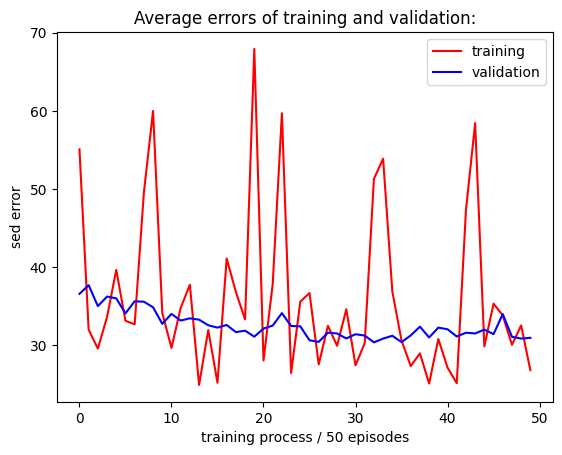

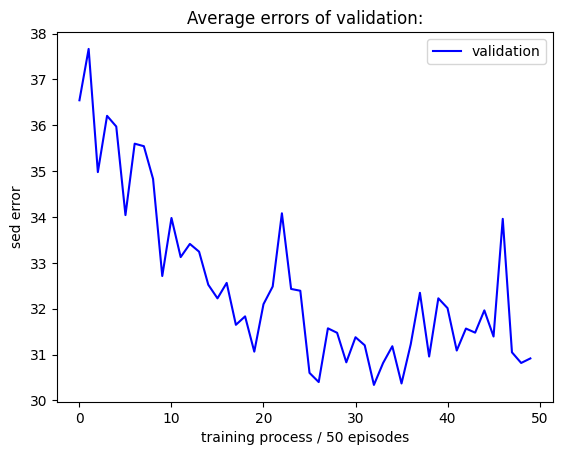

In [3]:
train(traj_amount=500, valid_amount=100, Round=5, show_time=50, ratio=0.1, a_size=3, s_size=3, label='sed')

======loading train data======
It cost 39.86516976356506s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


Training error: 59.73113351854593, Validation error: 33.65620356171116

Save model at round 0 episode 50 with error 33.65620356171116
==>current best model is 33.65620356171116 with ratio 0.1
It costs 160.5265121459961s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.14s/it]


Training error: 34.77460602053247, Validation error: 32.683242277179744
Save model at round 0 episode 100 with error 32.683242277179744
==>current best model is 32.683242277179744 with ratio 0.1
It costs 163.15725541114807s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


Training error: 31.809044545963552, Validation error: 36.700087527577324
Save model at round 0 episode 150 with error 36.700087527577324
==>current best model is 32.683242277179744 with ratio 0.1
It costs 164.65274143218994s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


Training error: 47.00629098001559, Validation error: 40.67133141094099
Save model at round 0 episode 200 with error 40.67133141094099
==>current best model is 32.683242277179744 with ratio 0.1
It costs 169.73312878608704s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.10s/it]


Training error: 33.44812319255644, Validation error: 31.74053397055757
Save model at round 0 episode 250 with error 31.74053397055757
==>current best model is 31.74053397055757 with ratio 0.1
It costs 162.6977252960205s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


Training error: 43.16642360190726, Validation error: 32.69960323662097
Save model at round 0 episode 300 with error 32.69960323662097
==>current best model is 31.74053397055757 with ratio 0.1
It costs 173.96574354171753s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


Training error: 30.853580669907174, Validation error: 32.68059393658255
Save model at round 0 episode 350 with error 32.68059393658255
==>current best model is 31.74053397055757 with ratio 0.1
It costs 165.31525826454163s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


Training error: 56.89684971643289, Validation error: 31.743212430821554
Save model at round 0 episode 400 with error 31.743212430821554
==>current best model is 31.74053397055757 with ratio 0.1
It costs 165.47435235977173s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 26.274084277908077, Validation error: 31.08210433641477
Save model at round 0 episode 450 with error 31.08210433641477
==>current best model is 31.08210433641477 with ratio 0.1
It costs 159.28674006462097s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 23.48844181751088, Validation error: 32.29055031527822
Save model at round 0 episode 500 with error 32.29055031527822
==>current best model is 31.08210433641477 with ratio 0.1
It costs 157.25363612174988s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 79.87874624455314, Validation error: 33.07721271229522
Save model at round 1 episode 50 with error 33.07721271229522
==>current best model is 31.08210433641477 with ratio 0.1
It costs 157.04117894172668s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 34.72382805577473, Validation error: 31.082545366499836
Save model at round 1 episode 100 with error 31.082545366499836
==>current best model is 31.08210433641477 with ratio 0.1
It costs 155.62184619903564s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 27.830123812255046, Validation error: 33.458796935205264
Save model at round 1 episode 150 with error 33.458796935205264
==>current best model is 31.08210433641477 with ratio 0.1
It costs 156.52369046211243s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 37.010613970278214, Validation error: 31.782474360972437
Save model at round 1 episode 200 with error 31.782474360972437
==>current best model is 31.08210433641477 with ratio 0.1
It costs 171.3746635913849s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Training error: 29.844080702330157, Validation error: 32.76295421029503
Save model at round 1 episode 250 with error 32.76295421029503
==>current best model is 31.08210433641477 with ratio 0.1
It costs 164.56210947036743s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 31.85430111509339, Validation error: 34.97037938514427
Save model at round 1 episode 300 with error 34.97037938514427
==>current best model is 31.08210433641477 with ratio 0.1
It costs 158.65496158599854s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it]


Training error: 37.17520147536536, Validation error: 38.636354134364645
Save model at round 1 episode 350 with error 38.636354134364645
==>current best model is 31.08210433641477 with ratio 0.1
It costs 162.49494671821594s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Training error: 30.605821478789302, Validation error: 33.078608603827504
Save model at round 1 episode 400 with error 33.078608603827504
==>current best model is 31.08210433641477 with ratio 0.1
It costs 163.6259319782257s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.10s/it]


Training error: 34.9060668374984, Validation error: 32.36308779244617
Save model at round 1 episode 450 with error 32.36308779244617
==>current best model is 31.08210433641477 with ratio 0.1
It costs 157.78006076812744s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.12s/it]


Training error: 45.040681685582584, Validation error: 34.93742711613284
Save model at round 1 episode 500 with error 34.93742711613284
==>current best model is 31.08210433641477 with ratio 0.1
It costs 162.2983593940735s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 42.33119755784033, Validation error: 34.195402510319674
Save model at round 2 episode 50 with error 34.195402510319674
==>current best model is 31.08210433641477 with ratio 0.1
It costs 160.87319231033325s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it]


Training error: 30.69675389533402, Validation error: 33.02130737368912
Save model at round 2 episode 100 with error 33.02130737368912
==>current best model is 31.08210433641477 with ratio 0.1
It costs 155.89385962486267s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 46.550705975900144, Validation error: 34.053921828475815
Save model at round 2 episode 150 with error 34.053921828475815
==>current best model is 31.08210433641477 with ratio 0.1
It costs 156.6518692970276s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Training error: 43.00660701947122, Validation error: 37.115224767259456
Save model at round 2 episode 200 with error 37.115224767259456
==>current best model is 31.08210433641477 with ratio 0.1
It costs 166.2973198890686s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 33.14338395799232, Validation error: 33.75724191372283
Save model at round 2 episode 250 with error 33.75724191372283
==>current best model is 31.08210433641477 with ratio 0.1
It costs 156.2552649974823s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 27.01160321120387, Validation error: 31.55697991034197
Save model at round 2 episode 300 with error 31.55697991034197
==>current best model is 31.08210433641477 with ratio 0.1
It costs 155.48930287361145s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 24.402970943299508, Validation error: 30.97740349701367
Save model at round 2 episode 350 with error 30.97740349701367
==>current best model is 30.97740349701367 with ratio 0.1
It costs 155.80714631080627s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 66.16986045990154, Validation error: 31.999752660265294
Save model at round 2 episode 400 with error 31.999752660265294
==>current best model is 30.97740349701367 with ratio 0.1
It costs 156.6415090560913s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 23.086991145802035, Validation error: 32.33314484096471
Save model at round 2 episode 450 with error 32.33314484096471
==>current best model is 30.97740349701367 with ratio 0.1
It costs 156.15509462356567s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 32.465034615301285, Validation error: 30.864128863242918
Save model at round 2 episode 500 with error 30.864128863242918
==>current best model is 30.864128863242918 with ratio 0.1
It costs 154.79565024375916s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 27.467959997784988, Validation error: 40.381916351801486
Save model at round 3 episode 50 with error 40.381916351801486
==>current best model is 30.864128863242918 with ratio 0.1
It costs 155.0607738494873s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/it]


Training error: 35.156416909700766, Validation error: 33.13766264792665
Save model at round 3 episode 100 with error 33.13766264792665
==>current best model is 30.864128863242918 with ratio 0.1
It costs 155.8342366218567s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 35.86546050282505, Validation error: 31.929550589448024
Save model at round 3 episode 150 with error 31.929550589448024
==>current best model is 30.864128863242918 with ratio 0.1
It costs 157.17234563827515s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 45.30479612470516, Validation error: 33.739752418420146
Save model at round 3 episode 200 with error 33.739752418420146
==>current best model is 30.864128863242918 with ratio 0.1
It costs 157.8785002231598s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 41.08500788493394, Validation error: 33.35400108037108
Save model at round 3 episode 250 with error 33.35400108037108
==>current best model is 30.864128863242918 with ratio 0.1
It costs 156.6559989452362s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 30.929718083212844, Validation error: 32.391512742571685
Save model at round 3 episode 300 with error 32.391512742571685
==>current best model is 30.864128863242918 with ratio 0.1
It costs 156.09077739715576s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 36.07148917198621, Validation error: 31.30744297861791
Save model at round 3 episode 350 with error 31.30744297861791
==>current best model is 30.864128863242918 with ratio 0.1
It costs 158.27419638633728s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 29.807213406352453, Validation error: 31.683251344743606
Save model at round 3 episode 400 with error 31.683251344743606
==>current best model is 30.864128863242918 with ratio 0.1
It costs 156.8188271522522s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 52.64400855698663, Validation error: 30.22013599773944
Save model at round 3 episode 450 with error 30.22013599773944
==>current best model is 30.22013599773944 with ratio 0.1
It costs 156.94926691055298s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 43.11455220089808, Validation error: 34.245405396676944
Save model at round 3 episode 500 with error 34.245405396676944
==>current best model is 30.22013599773944 with ratio 0.1
It costs 154.8003053665161s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


Training error: 30.371173351734942, Validation error: 31.44447382547006
Save model at round 4 episode 50 with error 31.44447382547006
==>current best model is 30.22013599773944 with ratio 0.1
It costs 165.43543767929077s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 36.44410145384096, Validation error: 34.22964826359016
Save model at round 4 episode 100 with error 34.22964826359016
==>current best model is 30.22013599773944 with ratio 0.1
It costs 155.53272151947021s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 48.935688246011495, Validation error: 31.188442178905202
Save model at round 4 episode 150 with error 31.188442178905202
==>current best model is 30.22013599773944 with ratio 0.1
It costs 156.86775469779968s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 25.791481871351838, Validation error: 32.969667063382474
Save model at round 4 episode 200 with error 32.969667063382474
==>current best model is 30.22013599773944 with ratio 0.1
It costs 156.0564751625061s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 29.951022124725664, Validation error: 33.66213748756586
Save model at round 4 episode 250 with error 33.66213748756586
==>current best model is 30.22013599773944 with ratio 0.1
It costs 156.85065865516663s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 49.30661782887154, Validation error: 34.7535646916705
Save model at round 4 episode 300 with error 34.7535646916705
==>current best model is 30.22013599773944 with ratio 0.1
It costs 157.36032032966614s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 36.96547875583581, Validation error: 36.343949105472454
Save model at round 4 episode 350 with error 36.343949105472454
==>current best model is 30.22013599773944 with ratio 0.1
It costs 158.5136215686798s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 39.76560894871907, Validation error: 32.785596284025544
Save model at round 4 episode 400 with error 32.785596284025544
==>current best model is 30.22013599773944 with ratio 0.1
It costs 156.8631670475006s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


Training error: 46.5798403200628, Validation error: 32.45210401454274
Save model at round 4 episode 450 with error 32.45210401454274
==>current best model is 30.22013599773944 with ratio 0.1
It costs 162.43186330795288s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 29.18448825512149, Validation error: 35.05299920476118
Save model at round 4 episode 500 with error 35.05299920476118
==>current best model is 30.22013599773944 with ratio 0.1
It costs 156.09719705581665s
Training elapsed time = %s 7974.447900056839


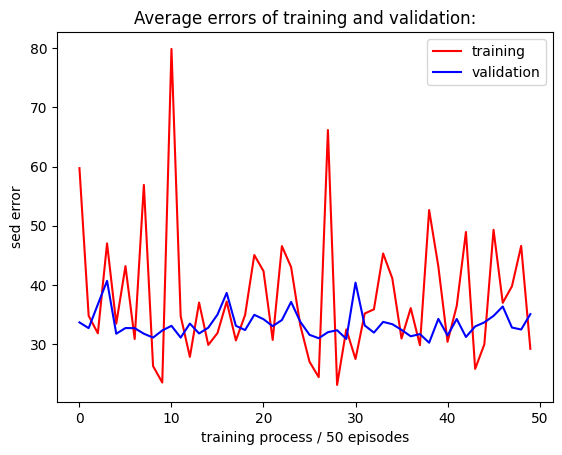

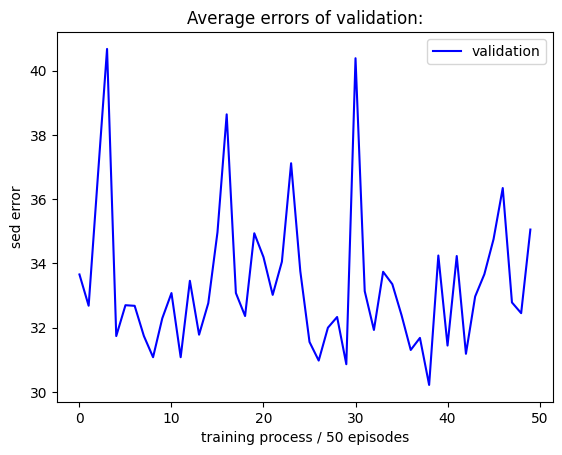

In [3]:
train(traj_amount=500, valid_amount=100, Round=5, show_time=50, ratio=0.1, a_size=3, s_size=3, learning_rate=0.01, label='sed')

======loading train data======
It cost 60.54399061203003s.


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 52.40907332589316, Validation error: 47.36357031554761
Save model at round 0 episode 50 with error 47.36357031554761
==>current best model is 47.36357031554761 with ratio 0.1
It costs 156.24532675743103s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 45.000956150078544, Validation error: 45.87299720649262
Save model at round 0 episode 100 with error 45.87299720649262
==>current best model is 45.87299720649262 with ratio 0.1
It costs 154.4603307247162s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 84.16367124364783, Validation error: 43.71493278895373
Save model at round 0 episode 150 with error 43.71493278895373
==>current best model is 43.71493278895373 with ratio 0.1
It costs 155.3569414615631s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 46.76895239726654, Validation error: 44.89340222925012
Save model at round 0 episode 200 with error 44.89340222925012
==>current best model is 43.71493278895373 with ratio 0.1
It costs 154.42819237709045s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 37.534736379065514, Validation error: 43.79352118248303
Save model at round 0 episode 250 with error 43.79352118248303
==>current best model is 43.71493278895373 with ratio 0.1
It costs 154.63655138015747s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 31.96627341015166, Validation error: 41.35608955349442
Save model at round 0 episode 300 with error 41.35608955349442
==>current best model is 41.35608955349442 with ratio 0.1
It costs 155.35272240638733s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 43.48930681537761, Validation error: 41.61798119364951
Save model at round 0 episode 350 with error 41.61798119364951
==>current best model is 41.35608955349442 with ratio 0.1
It costs 154.41874980926514s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 30.849205742134483, Validation error: 36.005797183351255
Save model at round 0 episode 400 with error 36.005797183351255
==>current best model is 36.005797183351255 with ratio 0.1
It costs 155.5496723651886s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 45.538545186566346, Validation error: 35.797018146847
Save model at round 0 episode 450 with error 35.797018146847
==>current best model is 35.797018146847 with ratio 0.1
It costs 154.32005715370178s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 47.19537063538318, Validation error: 35.686238810846966
Save model at round 0 episode 500 with error 35.686238810846966
==>current best model is 35.686238810846966 with ratio 0.1
It costs 156.29636335372925s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 57.27453540120905, Validation error: 33.89500127619511
Save model at round 1 episode 50 with error 33.89500127619511
==>current best model is 33.89500127619511 with ratio 0.1
It costs 154.34571385383606s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 39.32836956701819, Validation error: 34.99705693537719
Save model at round 1 episode 100 with error 34.99705693537719
==>current best model is 33.89500127619511 with ratio 0.1
It costs 154.11273670196533s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 36.05792948525744, Validation error: 34.785626621268655
Save model at round 1 episode 150 with error 34.785626621268655
==>current best model is 33.89500127619511 with ratio 0.1
It costs 154.91519594192505s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 28.944221619717997, Validation error: 35.611246017491546
Save model at round 1 episode 200 with error 35.611246017491546
==>current best model is 33.89500127619511 with ratio 0.1
It costs 154.8635392189026s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 31.348996195219573, Validation error: 34.87693334962121
Save model at round 1 episode 250 with error 34.87693334962121
==>current best model is 33.89500127619511 with ratio 0.1
It costs 154.20127749443054s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 32.8143615530198, Validation error: 35.664813363707395
Save model at round 1 episode 300 with error 35.664813363707395
==>current best model is 33.89500127619511 with ratio 0.1
It costs 155.47109246253967s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 42.966691334481176, Validation error: 35.970909365746316
Save model at round 1 episode 350 with error 35.970909365746316
==>current best model is 33.89500127619511 with ratio 0.1
It costs 155.6046221256256s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 28.13828075587813, Validation error: 33.782701086750464
Save model at round 1 episode 400 with error 33.782701086750464
==>current best model is 33.782701086750464 with ratio 0.1
It costs 154.96858429908752s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


Training error: 42.152058369815656, Validation error: 33.743221644211786
Save model at round 1 episode 450 with error 33.743221644211786
==>current best model is 33.743221644211786 with ratio 0.1
It costs 153.955157995224s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


Training error: 34.11073179441053, Validation error: 35.10707573193839
Save model at round 1 episode 500 with error 35.10707573193839
==>current best model is 33.743221644211786 with ratio 0.1
It costs 154.12592101097107s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 25.977228197896, Validation error: 35.30278751138629
Save model at round 2 episode 50 with error 35.30278751138629
==>current best model is 33.743221644211786 with ratio 0.1
It costs 155.18675184249878s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


Training error: 26.995513685242546, Validation error: 33.482676597246424
Save model at round 2 episode 100 with error 33.482676597246424
==>current best model is 33.482676597246424 with ratio 0.1
It costs 157.3076446056366s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


Training error: 30.772805014618434, Validation error: 34.088455821601926
Save model at round 2 episode 150 with error 34.088455821601926
==>current best model is 33.482676597246424 with ratio 0.1
It costs 152.41153645515442s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 42.215708449830345, Validation error: 34.349082071652504
Save model at round 2 episode 200 with error 34.349082071652504
==>current best model is 33.482676597246424 with ratio 0.1
It costs 155.21452474594116s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 31.078789953923025, Validation error: 34.65227271603207
Save model at round 2 episode 250 with error 34.65227271603207
==>current best model is 33.482676597246424 with ratio 0.1
It costs 155.32166647911072s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 34.083824991030546, Validation error: 32.0208097021821
Save model at round 2 episode 300 with error 32.0208097021821
==>current best model is 32.0208097021821 with ratio 0.1
It costs 155.27907752990723s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 66.8939704792768, Validation error: 34.49343406808573
Save model at round 2 episode 350 with error 34.49343406808573
==>current best model is 32.0208097021821 with ratio 0.1
It costs 155.2918140888214s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 27.528989751487842, Validation error: 33.01912345490633
Save model at round 2 episode 400 with error 33.01912345490633
==>current best model is 32.0208097021821 with ratio 0.1
It costs 154.7558388710022s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 36.41439585653382, Validation error: 33.93335383667374
Save model at round 2 episode 450 with error 33.93335383667374
==>current best model is 32.0208097021821 with ratio 0.1
It costs 155.03437685966492s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.02s/it]


Training error: 55.36056982448154, Validation error: 33.03476026946267
Save model at round 2 episode 500 with error 33.03476026946267
==>current best model is 32.0208097021821 with ratio 0.1
It costs 153.49033570289612s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 38.517842761244275, Validation error: 33.42045250912732
Save model at round 3 episode 50 with error 33.42045250912732
==>current best model is 32.0208097021821 with ratio 0.1
It costs 155.37950110435486s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 40.73463207055272, Validation error: 33.4838639014007
Save model at round 3 episode 100 with error 33.4838639014007
==>current best model is 32.0208097021821 with ratio 0.1
It costs 154.4228184223175s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 33.77109640483897, Validation error: 31.02057342740432
Save model at round 3 episode 150 with error 31.02057342740432
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.67565727233887s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 30.535596015947178, Validation error: 32.5040674566017
Save model at round 3 episode 200 with error 32.5040674566017
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.1654622554779s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 65.67091363347035, Validation error: 32.61111079681777
Save model at round 3 episode 250 with error 32.61111079681777
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.4314408302307s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 39.67153896141252, Validation error: 32.29997806268144
Save model at round 3 episode 300 with error 32.29997806268144
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.5883433818817s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 34.959546891909866, Validation error: 31.766320064278673
Save model at round 3 episode 350 with error 31.766320064278673
==>current best model is 31.02057342740432 with ratio 0.1
It costs 154.89887309074402s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 25.548356071806253, Validation error: 32.051532341938156
Save model at round 3 episode 400 with error 32.051532341938156
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.1781816482544s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 34.2865928894323, Validation error: 37.08140521663211
Save model at round 3 episode 450 with error 37.08140521663211
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.43528056144714s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 29.482925531161612, Validation error: 32.14515034214364
Save model at round 3 episode 500 with error 32.14515034214364
==>current best model is 31.02057342740432 with ratio 0.1
It costs 154.19996857643127s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 28.72760672580448, Validation error: 31.84920351224227
Save model at round 4 episode 50 with error 31.84920351224227
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.5138099193573s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 27.385684304054312, Validation error: 33.11125392003732
Save model at round 4 episode 100 with error 33.11125392003732
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.0286521911621s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 30.803792021360255, Validation error: 32.344954569438315
Save model at round 4 episode 150 with error 32.344954569438315
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.17903685569763s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 37.09998051632362, Validation error: 32.6921904515594
Save model at round 4 episode 200 with error 32.6921904515594
==>current best model is 31.02057342740432 with ratio 0.1
It costs 154.74927186965942s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


Training error: 40.36132041160784, Validation error: 32.518095452310966
Save model at round 4 episode 250 with error 32.518095452310966
==>current best model is 31.02057342740432 with ratio 0.1
It costs 160.51274967193604s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 47.555852393410284, Validation error: 33.209850631687544
Save model at round 4 episode 300 with error 33.209850631687544
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.6304202079773s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 34.03285689902291, Validation error: 33.35555596059018
Save model at round 4 episode 350 with error 33.35555596059018
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.3457314968109s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 70.30029117277233, Validation error: 33.07579054642131
Save model at round 4 episode 400 with error 33.07579054642131
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.4484133720398s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 35.39261430819604, Validation error: 32.519727526738485
Save model at round 4 episode 450 with error 32.519727526738485
==>current best model is 31.02057342740432 with ratio 0.1
It costs 154.91680812835693s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


Training error: 25.874733352056005, Validation error: 32.64846390243188
Save model at round 4 episode 500 with error 32.64846390243188
==>current best model is 31.02057342740432 with ratio 0.1
It costs 153.27972078323364s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 35.86474185438649, Validation error: 32.659487288955006
Save model at round 5 episode 50 with error 32.659487288955006
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.69068789482117s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 27.72231519963273, Validation error: 32.381479767821396
Save model at round 5 episode 100 with error 32.381479767821396
==>current best model is 31.02057342740432 with ratio 0.1
It costs 154.00970339775085s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 27.802716443573804, Validation error: 31.48928358727558
Save model at round 5 episode 150 with error 31.48928358727558
==>current best model is 31.02057342740432 with ratio 0.1
It costs 155.70028281211853s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 28.19060485307471, Validation error: 30.964511648985503
Save model at round 5 episode 200 with error 30.964511648985503
==>current best model is 30.964511648985503 with ratio 0.1
It costs 155.20462107658386s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 52.512887580784636, Validation error: 31.090862735720737
Save model at round 5 episode 250 with error 31.090862735720737
==>current best model is 30.964511648985503 with ratio 0.1
It costs 154.39317107200623s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 28.369767498575815, Validation error: 32.17540604380556
Save model at round 5 episode 300 with error 32.17540604380556
==>current best model is 30.964511648985503 with ratio 0.1
It costs 155.63917565345764s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 34.271374616372725, Validation error: 31.444913158778412
Save model at round 5 episode 350 with error 31.444913158778412
==>current best model is 30.964511648985503 with ratio 0.1
It costs 155.11731004714966s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 26.117332806230046, Validation error: 31.548619439335102
Save model at round 5 episode 400 with error 31.548619439335102
==>current best model is 30.964511648985503 with ratio 0.1
It costs 154.40087866783142s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 38.82871491908185, Validation error: 32.1876801323397
Save model at round 5 episode 450 with error 32.1876801323397
==>current best model is 30.964511648985503 with ratio 0.1
It costs 155.03182291984558s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 57.11768536567895, Validation error: 30.91856296684685
Save model at round 5 episode 500 with error 30.91856296684685
==>current best model is 30.91856296684685 with ratio 0.1
It costs 154.996267080307s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 22.6844752114087, Validation error: 30.535456017590604
Save model at round 6 episode 50 with error 30.535456017590604
==>current best model is 30.535456017590604 with ratio 0.1
It costs 154.90162014961243s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 22.601171440808898, Validation error: 30.57539807605323
Save model at round 6 episode 100 with error 30.57539807605323
==>current best model is 30.535456017590604 with ratio 0.1
It costs 154.93358826637268s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 44.18198267048663, Validation error: 32.344500257985665
Save model at round 6 episode 150 with error 32.344500257985665
==>current best model is 30.535456017590604 with ratio 0.1
It costs 154.82617449760437s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 31.22740508881041, Validation error: 31.584575217361806
Save model at round 6 episode 200 with error 31.584575217361806
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.6781084537506s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 36.02900154227831, Validation error: 31.5854897894645
Save model at round 6 episode 250 with error 31.5854897894645
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.53373742103577s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 27.547294609179847, Validation error: 31.23241799301034
Save model at round 6 episode 300 with error 31.23241799301034
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.05818128585815s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 73.92676154135007, Validation error: 31.68717082679141
Save model at round 6 episode 350 with error 31.68717082679141
==>current best model is 30.535456017590604 with ratio 0.1
It costs 154.22517609596252s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.12s/it]


Training error: 35.42928588076588, Validation error: 32.39495409385593
Save model at round 6 episode 400 with error 32.39495409385593
==>current best model is 30.535456017590604 with ratio 0.1
It costs 160.3236904144287s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 34.43114144449096, Validation error: 31.262719086939434
Save model at round 6 episode 450 with error 31.262719086939434
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.88265705108643s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 34.54666810471999, Validation error: 31.608971437131675
Save model at round 6 episode 500 with error 31.608971437131675
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.1398594379425s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 34.99283504656118, Validation error: 31.881574367949348
Save model at round 7 episode 50 with error 31.881574367949348
==>current best model is 30.535456017590604 with ratio 0.1
It costs 154.94765496253967s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 26.368721374840188, Validation error: 31.452785068693707
Save model at round 7 episode 100 with error 31.452785068693707
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.3093445301056s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 83.259612478506, Validation error: 31.795252959510286
Save model at round 7 episode 150 with error 31.795252959510286
==>current best model is 30.535456017590604 with ratio 0.1
It costs 154.0546796321869s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 38.62396106767097, Validation error: 31.551731966159956
Save model at round 7 episode 200 with error 31.551731966159956
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.31926107406616s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 27.73803614052295, Validation error: 30.84030921252919
Save model at round 7 episode 250 with error 30.84030921252919
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.25850915908813s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 27.699942841340377, Validation error: 31.54926613236652
Save model at round 7 episode 300 with error 31.54926613236652
==>current best model is 30.535456017590604 with ratio 0.1
It costs 156.62748169898987s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 44.76128820858949, Validation error: 32.36503019372884
Save model at round 7 episode 350 with error 32.36503019372884
==>current best model is 30.535456017590604 with ratio 0.1
It costs 154.12950801849365s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 31.70388613892914, Validation error: 30.999965549303248
Save model at round 7 episode 400 with error 30.999965549303248
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.0958161354065s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 28.104076772374402, Validation error: 32.480388143120656
Save model at round 7 episode 450 with error 32.480388143120656
==>current best model is 30.535456017590604 with ratio 0.1
It costs 155.98372745513916s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 36.67300989765035, Validation error: 31.321925256387345
Save model at round 7 episode 500 with error 31.321925256387345
==>current best model is 30.535456017590604 with ratio 0.1
It costs 157.21907258033752s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 32.843025700106224, Validation error: 29.892935908168525
Save model at round 8 episode 50 with error 29.892935908168525
==>current best model is 29.892935908168525 with ratio 0.1
It costs 154.85864543914795s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 25.880942504595506, Validation error: 30.398663904382115
Save model at round 8 episode 100 with error 30.398663904382115
==>current best model is 29.892935908168525 with ratio 0.1
It costs 154.51272988319397s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 32.52391444252948, Validation error: 31.335456499741298
Save model at round 8 episode 150 with error 31.335456499741298
==>current best model is 29.892935908168525 with ratio 0.1
It costs 155.52490091323853s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 33.788191238402625, Validation error: 31.543194712457336
Save model at round 8 episode 200 with error 31.543194712457336
==>current best model is 29.892935908168525 with ratio 0.1
It costs 156.39053416252136s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 28.927174064725587, Validation error: 31.63972254506827
Save model at round 8 episode 250 with error 31.63972254506827
==>current best model is 29.892935908168525 with ratio 0.1
It costs 155.4194724559784s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 51.05264637714206, Validation error: 31.24974863020774
Save model at round 8 episode 300 with error 31.24974863020774
==>current best model is 29.892935908168525 with ratio 0.1
It costs 155.41128420829773s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 22.552346666386935, Validation error: 31.032526498610242
Save model at round 8 episode 350 with error 31.032526498610242
==>current best model is 29.892935908168525 with ratio 0.1
It costs 156.23699426651s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 37.08127466635961, Validation error: 31.81996683170236
Save model at round 8 episode 400 with error 31.81996683170236
==>current best model is 29.892935908168525 with ratio 0.1
It costs 156.9158730506897s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 24.512073532620057, Validation error: 31.792483243986553
Save model at round 8 episode 450 with error 31.792483243986553
==>current best model is 29.892935908168525 with ratio 0.1
It costs 155.79022431373596s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 52.204307026445996, Validation error: 30.41893392859991
Save model at round 8 episode 500 with error 30.41893392859991
==>current best model is 29.892935908168525 with ratio 0.1
It costs 156.14613580703735s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 31.12612688897265, Validation error: 31.001282488224074
Save model at round 9 episode 50 with error 31.001282488224074
==>current best model is 29.892935908168525 with ratio 0.1
It costs 161.03274178504944s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 28.34469451034972, Validation error: 31.04750506613549
Save model at round 9 episode 100 with error 31.04750506613549
==>current best model is 29.892935908168525 with ratio 0.1
It costs 156.0948178768158s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 29.216125253468828, Validation error: 31.91814489770983
Save model at round 9 episode 150 with error 31.91814489770983
==>current best model is 29.892935908168525 with ratio 0.1
It costs 156.10848355293274s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 40.71881093435016, Validation error: 31.04842570804396
Save model at round 9 episode 200 with error 31.04842570804396
==>current best model is 29.892935908168525 with ratio 0.1
It costs 156.81823897361755s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 39.19303716481143, Validation error: 30.414716852473738
Save model at round 9 episode 250 with error 30.414716852473738
==>current best model is 29.892935908168525 with ratio 0.1
It costs 154.7359175682068s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 28.477075484764704, Validation error: 31.957787835135203
Save model at round 9 episode 300 with error 31.957787835135203
==>current best model is 29.892935908168525 with ratio 0.1
It costs 156.72501611709595s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 38.029513537946684, Validation error: 30.781328488290782
Save model at round 9 episode 350 with error 30.781328488290782
==>current best model is 29.892935908168525 with ratio 0.1
It costs 157.56300139427185s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 29.98661167477211, Validation error: 33.00067289789118
Save model at round 9 episode 400 with error 33.00067289789118
==>current best model is 29.892935908168525 with ratio 0.1
It costs 154.91207671165466s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 27.029998974265297, Validation error: 30.408351406916264
Save model at round 9 episode 450 with error 30.408351406916264
==>current best model is 29.892935908168525 with ratio 0.1
It costs 158.36800384521484s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Training error: 71.41709771594788, Validation error: 32.263236780706784
Save model at round 9 episode 500 with error 32.263236780706784
==>current best model is 29.892935908168525 with ratio 0.1
It costs 156.51133704185486s
Training elapsed time = %s 15540.617203474045


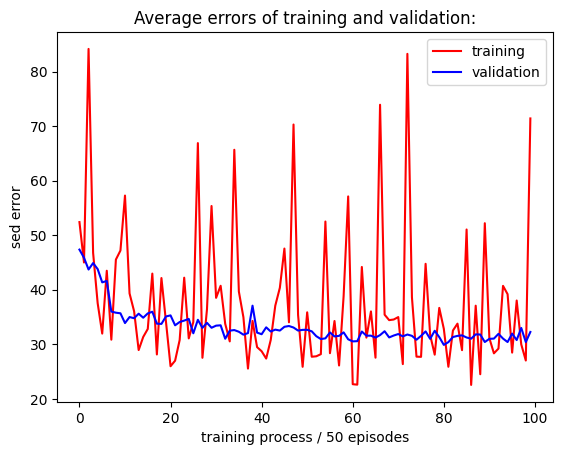

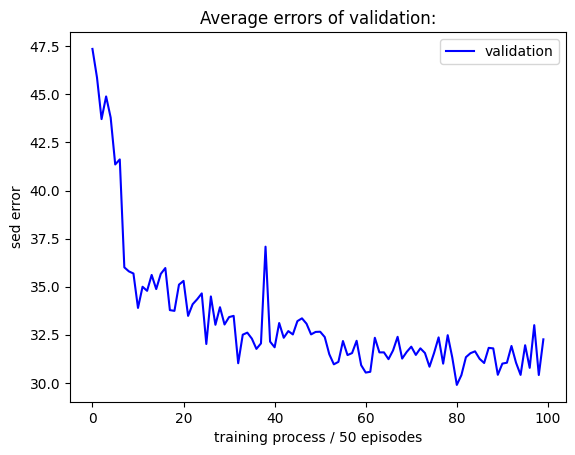

In [4]:
train(traj_amount=500, valid_amount=100, Round=10, show_time=50, ratio=0.1, a_size=3, s_size=3, learning_rate=0.001, label='sed')

======loading train data======
It cost 36.757389307022095s.


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 29.132885856593642, Validation error: 18.6251031391978
Save model at round 0 episode 50 with error 18.6251031391978
==>current best model is 18.6251031391978 with ratio 0.1
It costs 144.03304243087769s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 17.201622332301767, Validation error: 16.39257617936882
Save model at round 0 episode 100 with error 16.39257617936882
==>current best model is 16.39257617936882 with ratio 0.1
It costs 145.66542220115662s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


Training error: 11.532993031336183, Validation error: 20.119433547454356
Save model at round 0 episode 150 with error 20.119433547454356
==>current best model is 16.39257617936882 with ratio 0.1
It costs 146.1906440258026s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 28.47493534778026, Validation error: 17.456564901175675
Save model at round 0 episode 200 with error 17.456564901175675
==>current best model is 16.39257617936882 with ratio 0.1
It costs 145.45310807228088s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 35.53444188624772, Validation error: 19.659189701946847
Save model at round 0 episode 250 with error 19.659189701946847
==>current best model is 16.39257617936882 with ratio 0.1
It costs 144.7861020565033s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 12.40558341390306, Validation error: 17.28668020806492
Save model at round 0 episode 300 with error 17.28668020806492
==>current best model is 16.39257617936882 with ratio 0.1
It costs 144.83627843856812s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 18.23560710440481, Validation error: 17.881842282515642
Save model at round 0 episode 350 with error 17.881842282515642
==>current best model is 16.39257617936882 with ratio 0.1
It costs 145.36274027824402s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 13.830954471642036, Validation error: 17.857912386821752
Save model at round 0 episode 400 with error 17.857912386821752
==>current best model is 16.39257617936882 with ratio 0.1
It costs 144.57916355133057s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 12.824196783530304, Validation error: 18.060398716513536
Save model at round 0 episode 450 with error 18.060398716513536
==>current best model is 16.39257617936882 with ratio 0.1
It costs 145.2222318649292s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 19.92048223578963, Validation error: 18.32478827322172
Save model at round 0 episode 500 with error 18.32478827322172
==>current best model is 16.39257617936882 with ratio 0.1
It costs 144.98127961158752s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 10.175906450356342, Validation error: 18.161743600674946
Save model at round 1 episode 50 with error 18.161743600674946
==>current best model is 16.39257617936882 with ratio 0.1
It costs 143.74259567260742s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 17.943968024159147, Validation error: 15.115227865531448
Save model at round 1 episode 100 with error 15.115227865531448
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.39147877693176s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 25.435074044195495, Validation error: 17.806916731197596
Save model at round 1 episode 150 with error 17.806916731197596
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.70365238189697s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 13.89566443789057, Validation error: 17.973570993630755
Save model at round 1 episode 200 with error 17.973570993630755
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.73600101470947s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


Training error: 20.194407648267507, Validation error: 17.364834803382717
Save model at round 1 episode 250 with error 17.364834803382717
==>current best model is 15.115227865531448 with ratio 0.1
It costs 150.120258808136s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 28.879648328796176, Validation error: 16.487509928198534
Save model at round 1 episode 300 with error 16.487509928198534
==>current best model is 15.115227865531448 with ratio 0.1
It costs 143.1399326324463s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 29.72438306350442, Validation error: 17.28811575058352
Save model at round 1 episode 350 with error 17.28811575058352
==>current best model is 15.115227865531448 with ratio 0.1
It costs 143.00480914115906s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 12.908408444134068, Validation error: 18.5667826737503
Save model at round 1 episode 400 with error 18.5667826737503
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.08067750930786s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 12.274565904900394, Validation error: 15.651078980856264
Save model at round 1 episode 450 with error 15.651078980856264
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.71008205413818s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 19.1838344678359, Validation error: 18.036288325331405
Save model at round 1 episode 500 with error 18.036288325331405
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.00683569908142s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 15.076192435703113, Validation error: 15.988977743067789
Save model at round 2 episode 50 with error 15.988977743067789
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.9448366165161s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 16.42791532016997, Validation error: 16.307823622958562
Save model at round 2 episode 100 with error 16.307823622958562
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.27346539497375s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 40.11671205270357, Validation error: 17.882063303820768
Save model at round 2 episode 150 with error 17.882063303820768
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.43250250816345s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 15.56317101150979, Validation error: 15.598547425730116
Save model at round 2 episode 200 with error 15.598547425730116
==>current best model is 15.115227865531448 with ratio 0.1
It costs 143.69527578353882s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 17.762332826511386, Validation error: 17.179599952121567
Save model at round 2 episode 250 with error 17.179599952121567
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.41652727127075s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 12.296987427890931, Validation error: 18.318528906085625
Save model at round 2 episode 300 with error 18.318528906085625
==>current best model is 15.115227865531448 with ratio 0.1
It costs 143.63210916519165s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 15.396319113513677, Validation error: 16.200454291311516
Save model at round 2 episode 350 with error 16.200454291311516
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.54406929016113s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 18.087780540217754, Validation error: 15.898745410397071
Save model at round 2 episode 400 with error 15.898745410397071
==>current best model is 15.115227865531448 with ratio 0.1
It costs 146.03280067443848s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 25.42589709826137, Validation error: 16.92213196751402
Save model at round 2 episode 450 with error 16.92213196751402
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.11824536323547s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 12.78020161967674, Validation error: 16.24537098949558
Save model at round 2 episode 500 with error 16.24537098949558
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.49694919586182s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 14.034540009213346, Validation error: 18.12442082898671
Save model at round 3 episode 50 with error 18.12442082898671
==>current best model is 15.115227865531448 with ratio 0.1
It costs 143.17084741592407s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 15.96784161841022, Validation error: 16.056907164315366
Save model at round 3 episode 100 with error 16.056907164315366
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.99746203422546s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 17.63657151248926, Validation error: 17.048602138235594
Save model at round 3 episode 150 with error 17.048602138235594
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.5687005519867s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 15.555874822658689, Validation error: 20.494866567266687
Save model at round 3 episode 200 with error 20.494866567266687
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.52836298942566s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 29.56243102264464, Validation error: 19.15963030235261
Save model at round 3 episode 250 with error 19.15963030235261
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.3143630027771s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 14.56561940671775, Validation error: 18.20611031414524
Save model at round 3 episode 300 with error 18.20611031414524
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.7042841911316s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 12.137426718226939, Validation error: 17.90701071736499
Save model at round 3 episode 350 with error 17.90701071736499
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.3110387325287s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 13.925313351992196, Validation error: 15.420552038719986
Save model at round 3 episode 400 with error 15.420552038719986
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.57336354255676s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 22.415193390569037, Validation error: 17.04200696949568
Save model at round 3 episode 450 with error 17.04200696949568
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.06265497207642s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00it/s]


Training error: 27.99892849971285, Validation error: 15.864033247645578
Save model at round 3 episode 500 with error 15.864033247645578
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.59949493408203s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 39.197165510321966, Validation error: 16.52030374274313
Save model at round 4 episode 50 with error 16.52030374274313
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.03863644599915s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 11.495877178483427, Validation error: 17.46546875511637
Save model at round 4 episode 100 with error 17.46546875511637
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.73717260360718s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 24.89922612204832, Validation error: 19.837222118395495
Save model at round 4 episode 150 with error 19.837222118395495
==>current best model is 15.115227865531448 with ratio 0.1
It costs 144.8608078956604s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 23.780897940512077, Validation error: 15.294494327819773
Save model at round 4 episode 200 with error 15.294494327819773
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.04748582839966s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 11.533367122508238, Validation error: 16.956362119185965
Save model at round 4 episode 250 with error 16.956362119185965
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.42848777770996s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 14.14639427009222, Validation error: 16.49526651838416
Save model at round 4 episode 300 with error 16.49526651838416
==>current best model is 15.115227865531448 with ratio 0.1
It costs 145.48991060256958s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 26.031419544670033, Validation error: 14.519866182113772
Save model at round 4 episode 350 with error 14.519866182113772
==>current best model is 14.519866182113772 with ratio 0.1
It costs 146.0682783126831s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 12.143436198994722, Validation error: 16.147888867142143
Save model at round 4 episode 400 with error 16.147888867142143
==>current best model is 14.519866182113772 with ratio 0.1
It costs 143.83958506584167s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 15.620729544265668, Validation error: 17.2654158592566
Save model at round 4 episode 450 with error 17.2654158592566
==>current best model is 14.519866182113772 with ratio 0.1
It costs 144.8498466014862s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 14.450142987916268, Validation error: 16.3597939259237
Save model at round 4 episode 500 with error 16.3597939259237
==>current best model is 14.519866182113772 with ratio 0.1
It costs 145.4782326221466s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 31.813710818100503, Validation error: 17.08552643183597
Save model at round 5 episode 50 with error 17.08552643183597
==>current best model is 14.519866182113772 with ratio 0.1
It costs 144.84003925323486s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 25.073714783338538, Validation error: 16.76553897569022
Save model at round 5 episode 100 with error 16.76553897569022
==>current best model is 14.519866182113772 with ratio 0.1
It costs 147.49111342430115s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 20.550830323697923, Validation error: 14.493074583886294
Save model at round 5 episode 150 with error 14.493074583886294
==>current best model is 14.493074583886294 with ratio 0.1
It costs 145.10166120529175s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 14.343787672045647, Validation error: 16.206828232596887
Save model at round 5 episode 200 with error 16.206828232596887
==>current best model is 14.493074583886294 with ratio 0.1
It costs 143.93327140808105s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


Training error: 13.032342937570727, Validation error: 16.032760765342545
Save model at round 5 episode 250 with error 16.032760765342545
==>current best model is 14.493074583886294 with ratio 0.1
It costs 146.5651261806488s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 14.248797717462766, Validation error: 17.025989224656964
Save model at round 5 episode 300 with error 17.025989224656964
==>current best model is 14.493074583886294 with ratio 0.1
It costs 143.89288568496704s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00it/s]


Training error: 18.000154117059626, Validation error: 17.859565059366208
Save model at round 5 episode 350 with error 17.859565059366208
==>current best model is 14.493074583886294 with ratio 0.1
It costs 146.65634036064148s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 28.34354063267425, Validation error: 15.401602153640278
Save model at round 5 episode 400 with error 15.401602153640278
==>current best model is 14.493074583886294 with ratio 0.1
It costs 144.3731746673584s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 13.720492321657687, Validation error: 16.56526882678052
Save model at round 5 episode 450 with error 16.56526882678052
==>current best model is 14.493074583886294 with ratio 0.1
It costs 145.63736176490784s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.02s/it]


Training error: 10.899375997361085, Validation error: 16.68104142152033
Save model at round 5 episode 500 with error 16.68104142152033
==>current best model is 14.493074583886294 with ratio 0.1
It costs 147.08620142936707s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 32.090964876354256, Validation error: 17.33254487683005
Save model at round 6 episode 50 with error 17.33254487683005
==>current best model is 14.493074583886294 with ratio 0.1
It costs 145.58756256103516s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 17.36708511869601, Validation error: 16.582352014463293
Save model at round 6 episode 100 with error 16.582352014463293
==>current best model is 14.493074583886294 with ratio 0.1
It costs 143.81934785842896s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 15.077893093376037, Validation error: 14.9817701142539
Save model at round 6 episode 150 with error 14.9817701142539
==>current best model is 14.493074583886294 with ratio 0.1
It costs 145.1396553516388s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 13.439728773608543, Validation error: 14.543553311114565
Save model at round 6 episode 200 with error 14.543553311114565
==>current best model is 14.493074583886294 with ratio 0.1
It costs 147.67200374603271s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


Training error: 15.117579167252641, Validation error: 15.608383989433225
Save model at round 6 episode 250 with error 15.608383989433225
==>current best model is 14.493074583886294 with ratio 0.1
It costs 148.18879437446594s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 26.84908616482645, Validation error: 17.188033357867127
Save model at round 6 episode 300 with error 17.188033357867127
==>current best model is 14.493074583886294 with ratio 0.1
It costs 143.77173709869385s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 12.813320708405682, Validation error: 16.297558426553245
Save model at round 6 episode 350 with error 16.297558426553245
==>current best model is 14.493074583886294 with ratio 0.1
It costs 145.3577847480774s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 11.221591821235313, Validation error: 16.027069754065657
Save model at round 6 episode 400 with error 16.027069754065657
==>current best model is 14.493074583886294 with ratio 0.1
It costs 145.54130601882935s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 23.793608528151047, Validation error: 14.949153311983856
Save model at round 6 episode 450 with error 14.949153311983856
==>current best model is 14.493074583886294 with ratio 0.1
It costs 146.11995697021484s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 11.88204563165991, Validation error: 17.611844418847642
Save model at round 6 episode 500 with error 17.611844418847642
==>current best model is 14.493074583886294 with ratio 0.1
It costs 146.0346074104309s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 17.943254739679208, Validation error: 15.222364622429563
Save model at round 7 episode 50 with error 15.222364622429563
==>current best model is 14.493074583886294 with ratio 0.1
It costs 144.38271379470825s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 11.654506524307651, Validation error: 14.502230375142558
Save model at round 7 episode 100 with error 14.502230375142558
==>current best model is 14.493074583886294 with ratio 0.1
It costs 145.29111504554749s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 11.41044505955433, Validation error: 16.251657028467346
Save model at round 7 episode 150 with error 16.251657028467346
==>current best model is 14.493074583886294 with ratio 0.1
It costs 146.1601047515869s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 11.82959113684014, Validation error: 16.109462316388054
Save model at round 7 episode 200 with error 16.109462316388054
==>current best model is 14.493074583886294 with ratio 0.1
It costs 145.48076510429382s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 27.49007913743456, Validation error: 15.877681059802423
Save model at round 7 episode 250 with error 15.877681059802423
==>current best model is 14.493074583886294 with ratio 0.1
It costs 144.2912838459015s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 24.781877531744016, Validation error: 14.403055255621382
Save model at round 7 episode 300 with error 14.403055255621382
==>current best model is 14.403055255621382 with ratio 0.1
It costs 145.19485211372375s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00it/s]


Training error: 30.549150196432276, Validation error: 16.92467483786178
Save model at round 7 episode 350 with error 16.92467483786178
==>current best model is 14.403055255621382 with ratio 0.1
It costs 147.63726830482483s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 14.214622830017994, Validation error: 17.081452551145894
Save model at round 7 episode 400 with error 17.081452551145894
==>current best model is 14.403055255621382 with ratio 0.1
It costs 146.49395871162415s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 14.51514479009466, Validation error: 17.85751503937256
Save model at round 7 episode 450 with error 17.85751503937256
==>current best model is 14.403055255621382 with ratio 0.1
It costs 144.48462557792664s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 17.914128404427732, Validation error: 15.448104623168465
Save model at round 7 episode 500 with error 15.448104623168465
==>current best model is 14.403055255621382 with ratio 0.1
It costs 144.77778458595276s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 15.140504794826676, Validation error: 16.082675752669083
Save model at round 8 episode 50 with error 16.082675752669083
==>current best model is 14.403055255621382 with ratio 0.1
It costs 146.2207522392273s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 12.812783690394248, Validation error: 15.525393720307639
Save model at round 8 episode 100 with error 15.525393720307639
==>current best model is 14.403055255621382 with ratio 0.1
It costs 145.40596914291382s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 31.769051642662546, Validation error: 17.053250953773407
Save model at round 8 episode 150 with error 17.053250953773407
==>current best model is 14.403055255621382 with ratio 0.1
It costs 146.6816897392273s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 22.322770057208622, Validation error: 15.468040655231636
Save model at round 8 episode 200 with error 15.468040655231636
==>current best model is 14.403055255621382 with ratio 0.1
It costs 146.5356090068817s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 14.388128065508162, Validation error: 15.58514129720159
Save model at round 8 episode 250 with error 15.58514129720159
==>current best model is 14.403055255621382 with ratio 0.1
It costs 144.73380970954895s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 13.293682084233126, Validation error: 15.772029871372867
Save model at round 8 episode 300 with error 15.772029871372867
==>current best model is 14.403055255621382 with ratio 0.1
It costs 144.50187253952026s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 18.990764458222433, Validation error: 14.610168884761004
Save model at round 8 episode 350 with error 14.610168884761004
==>current best model is 14.403055255621382 with ratio 0.1
It costs 144.72774243354797s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


Training error: 15.246668491392962, Validation error: 15.639239968570573
Save model at round 8 episode 400 with error 15.639239968570573
==>current best model is 14.403055255621382 with ratio 0.1
It costs 150.9433422088623s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 22.91024081618157, Validation error: 16.330538141429425
Save model at round 8 episode 450 with error 16.330538141429425
==>current best model is 14.403055255621382 with ratio 0.1
It costs 145.0602297782898s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 16.24583835045494, Validation error: 14.696656447678157
Save model at round 8 episode 500 with error 14.696656447678157
==>current best model is 14.403055255621382 with ratio 0.1
It costs 147.11176657676697s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 13.453339903664839, Validation error: 15.26843962475253
Save model at round 9 episode 50 with error 15.26843962475253
==>current best model is 14.403055255621382 with ratio 0.1
It costs 145.52577471733093s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00it/s]


Training error: 13.923106652736605, Validation error: 15.378618386122758
Save model at round 9 episode 100 with error 15.378618386122758
==>current best model is 14.403055255621382 with ratio 0.1
It costs 148.16537499427795s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 23.321261649492325, Validation error: 16.45443879041755
Save model at round 9 episode 150 with error 16.45443879041755
==>current best model is 14.403055255621382 with ratio 0.1
It costs 145.50210165977478s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 14.434428227998566, Validation error: 14.771411690041937
Save model at round 9 episode 200 with error 14.771411690041937
==>current best model is 14.403055255621382 with ratio 0.1
It costs 147.5342562198639s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 14.44756260591714, Validation error: 18.112693797154236
Save model at round 9 episode 250 with error 18.112693797154236
==>current best model is 14.403055255621382 with ratio 0.1
It costs 146.14233112335205s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 25.768701596835303, Validation error: 15.865458389246907
Save model at round 9 episode 300 with error 15.865458389246907
==>current best model is 14.403055255621382 with ratio 0.1
It costs 146.47465825080872s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 13.715380109406851, Validation error: 14.551417987784651
Save model at round 9 episode 350 with error 14.551417987784651
==>current best model is 14.403055255621382 with ratio 0.1
It costs 144.90543794631958s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00it/s]


Training error: 18.249022973830307, Validation error: 14.559419040975708
Save model at round 9 episode 400 with error 14.559419040975708
==>current best model is 14.403055255621382 with ratio 0.1
It costs 146.97767424583435s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 25.082957077376605, Validation error: 14.159828261591342
Save model at round 9 episode 450 with error 14.159828261591342
==>current best model is 14.159828261591342 with ratio 0.1
It costs 146.38894844055176s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 14.746470241730766, Validation error: 14.958683991107955
Save model at round 9 episode 500 with error 14.958683991107955
==>current best model is 14.159828261591342 with ratio 0.1
It costs 145.99816703796387s
Training elapsed time = %s 14537.54970574379


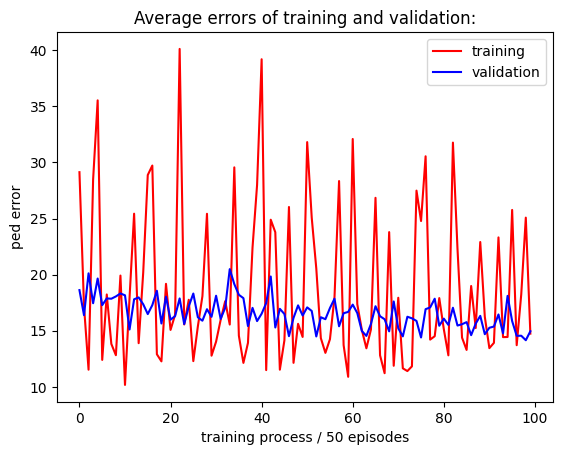

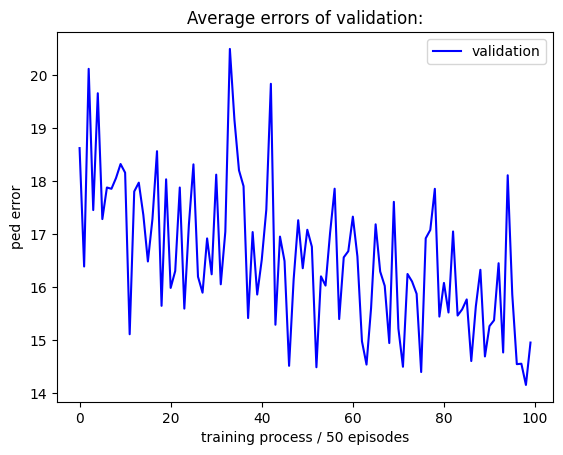

In [5]:
train(traj_amount=500, valid_amount=100, Round=10, show_time=50, ratio=0.1, a_size=3, s_size=3, learning_rate=0.001, label='ped')

======loading train data======
It cost 25.633671760559082s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


Training error: 42.21150037547078, Validation error: 36.72671873540606

Save model at round 0 episode 50 with error 36.72671873540606
==>current best model is 36.72671873540606 with ratio 0.1
It costs 81.0762243270874s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]


Training error: 45.97729263394335, Validation error: 36.85772146953192
==>current best model is 36.72671873540606 with ratio 0.1
It costs 101.38575291633606s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.39it/s]


Training error: 79.50266837333022, Validation error: 36.75227333369954
==>current best model is 36.72671873540606 with ratio 0.1
It costs 100.87243175506592s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


Training error: 52.23969638279821, Validation error: 34.637434832935625
Save model at round 0 episode 200 with error 34.637434832935625
==>current best model is 34.637434832935625 with ratio 0.1
It costs 99.10103011131287s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.39it/s]


Training error: 30.37493584766412, Validation error: 35.56574776946797
==>current best model is 34.637434832935625 with ratio 0.1
It costs 101.06455993652344s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


Training error: 37.0458146427203, Validation error: 34.7026194556204
==>current best model is 34.637434832935625 with ratio 0.1
It costs 98.9722044467926s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.49it/s]


Training error: 35.46714989231103, Validation error: 35.47125167668089
==>current best model is 34.637434832935625 with ratio 0.1
It costs 96.17401790618896s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


Training error: 113.05854952435224, Validation error: 36.565049798638405
==>current best model is 34.637434832935625 with ratio 0.1
It costs 101.54457831382751s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.40it/s]


Training error: 37.81748356085832, Validation error: 34.02283101224692
Save model at round 0 episode 450 with error 34.02283101224692
==>current best model is 34.02283101224692 with ratio 0.1
It costs 94.12768363952637s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Training error: 36.30713622141427, Validation error: 34.42574919541559
==>current best model is 34.02283101224692 with ratio 0.1
It costs 92.14048552513123s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


Training error: 51.30103391728842, Validation error: 35.55789251033127
==>current best model is 34.02283101224692 with ratio 0.1
It costs 93.26921510696411s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


Training error: 39.45366826121656, Validation error: 34.55438329522325
==>current best model is 34.02283101224692 with ratio 0.1
It costs 96.62286567687988s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.43it/s]


Training error: 38.40631216102729, Validation error: 34.8955112238405
==>current best model is 34.02283101224692 with ratio 0.1
It costs 95.50121855735779s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


Training error: 98.55168830267309, Validation error: 33.66531063063729
Save model at round 1 episode 200 with error 33.66531063063729
==>current best model is 33.66531063063729 with ratio 0.1
It costs 93.26815581321716s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


Training error: 37.09771536472617, Validation error: 35.46838790705623
==>current best model is 33.66531063063729 with ratio 0.1
It costs 92.63039946556091s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


Training error: 89.33781018236506, Validation error: 34.5010711970449
==>current best model is 33.66531063063729 with ratio 0.1
It costs 93.32508444786072s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


Training error: 38.07333225857267, Validation error: 33.293670273660375
Save model at round 1 episode 350 with error 33.293670273660375
==>current best model is 33.293670273660375 with ratio 0.1
It costs 93.65591478347778s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


Training error: 33.55589566272165, Validation error: 35.4836080670985
==>current best model is 33.293670273660375 with ratio 0.1
It costs 93.27469229698181s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


Training error: 49.1862542330734, Validation error: 35.16583160926356
==>current best model is 33.293670273660375 with ratio 0.1
It costs 94.05845046043396s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]


Training error: 39.49458037222404, Validation error: 33.68141355382447
==>current best model is 33.293670273660375 with ratio 0.1
It costs 93.97675275802612s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


Training error: 36.13578497438801, Validation error: 34.22239797222971
==>current best model is 33.293670273660375 with ratio 0.1
It costs 93.19070863723755s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Training error: 33.70146214352446, Validation error: 34.14829215563455
==>current best model is 33.293670273660375 with ratio 0.1
It costs 91.3086245059967s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


Training error: 87.55030982243497, Validation error: 36.81186854905893
==>current best model is 33.293670273660375 with ratio 0.1
It costs 92.46582508087158s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


Training error: 35.501028506713006, Validation error: 33.58692788385913
==>current best model is 33.293670273660375 with ratio 0.1
It costs 96.04671430587769s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


Training error: 38.76476778666454, Validation error: 34.34708642954574
==>current best model is 33.293670273660375 with ratio 0.1
It costs 87.78883957862854s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


Training error: 45.93270786012707, Validation error: 32.665488029883555
Save model at round 2 episode 300 with error 32.665488029883555
==>current best model is 32.665488029883555 with ratio 0.1
It costs 96.91921377182007s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


Training error: 48.38662199466185, Validation error: 33.46211462736919
==>current best model is 32.665488029883555 with ratio 0.1
It costs 92.07132148742676s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


Training error: 48.235955900968605, Validation error: 34.12380113226924
==>current best model is 32.665488029883555 with ratio 0.1
It costs 91.73151731491089s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


Training error: 97.35964330326593, Validation error: 34.79418530933319
==>current best model is 32.665488029883555 with ratio 0.1
It costs 92.47495913505554s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Training error: 31.349234995831356, Validation error: 34.152553737721604
==>current best model is 32.665488029883555 with ratio 0.1
It costs 92.07863903045654s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Training error: 80.10176024910031, Validation error: 33.476475174374606
==>current best model is 32.665488029883555 with ratio 0.1
It costs 90.60838890075684s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Training error: 31.1393909067491, Validation error: 34.78393765863561
==>current best model is 32.665488029883555 with ratio 0.1
It costs 93.02107453346252s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


Training error: 34.508407771912836, Validation error: 33.44261775228462
==>current best model is 32.665488029883555 with ratio 0.1
It costs 92.47168779373169s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


Training error: 96.7435955492248, Validation error: 32.3621193832846
Save model at round 3 episode 200 with error 32.3621193832846
==>current best model is 32.3621193832846 with ratio 0.1
It costs 92.55443787574768s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


Training error: 36.36160312990937, Validation error: 33.26215102196686
==>current best model is 32.3621193832846 with ratio 0.1
It costs 92.45858383178711s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]


Training error: 33.507617807639726, Validation error: 33.41161263136365
==>current best model is 32.3621193832846 with ratio 0.1
It costs 95.8013129234314s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.49it/s]


Training error: 36.68964752197497, Validation error: 33.31264488099704
==>current best model is 32.3621193832846 with ratio 0.1
It costs 94.06487512588501s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


Training error: 28.692496942313824, Validation error: 33.154598548851105
==>current best model is 32.3621193832846 with ratio 0.1
It costs 95.30943441390991s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]


Training error: 41.60348845709407, Validation error: 32.41979443238708
==>current best model is 32.3621193832846 with ratio 0.1
It costs 94.6152024269104s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]


Training error: 50.98732872736342, Validation error: 32.11930598255567
Save model at round 3 episode 500 with error 32.11930598255567
==>current best model is 32.11930598255567 with ratio 0.1
It costs 97.4526481628418s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]


Training error: 36.727897331136916, Validation error: 32.52955902671811
==>current best model is 32.11930598255567 with ratio 0.1
It costs 95.36217498779297s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.44it/s]


Training error: 30.1780040851996, Validation error: 32.91703066502188
==>current best model is 32.11930598255567 with ratio 0.1
It costs 95.33372402191162s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.42it/s]


Training error: 79.34223108024248, Validation error: 34.6636574547368
==>current best model is 32.11930598255567 with ratio 0.1
It costs 97.38461446762085s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


Training error: 38.02386018171305, Validation error: 34.21848459436996
==>current best model is 32.11930598255567 with ratio 0.1
It costs 92.74970030784607s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


Training error: 35.734856778949734, Validation error: 34.22258685622622
==>current best model is 32.11930598255567 with ratio 0.1
It costs 93.87363648414612s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]


Training error: 107.31907412526262, Validation error: 32.336601129501545
==>current best model is 32.11930598255567 with ratio 0.1
It costs 94.99629664421082s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.39it/s]


Training error: 34.02172713925984, Validation error: 33.93089923461085
==>current best model is 32.11930598255567 with ratio 0.1
It costs 98.59896492958069s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


Training error: 54.830257593960305, Validation error: 32.48256032498996
==>current best model is 32.11930598255567 with ratio 0.1
It costs 93.17668461799622s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


Training error: 43.37835463472443, Validation error: 32.48649459509559
==>current best model is 32.11930598255567 with ratio 0.1
It costs 91.51722264289856s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.42it/s]


Training error: 35.45020488868466, Validation error: 33.17285709662995
==>current best model is 32.11930598255567 with ratio 0.1
It costs 95.62460398674011s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Training error: 31.023546550057432, Validation error: 32.56630732753969
==>current best model is 32.11930598255567 with ratio 0.1
It costs 91.95038270950317s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


Training error: 39.64166740996569, Validation error: 33.03111221509574
==>current best model is 32.11930598255567 with ratio 0.1
It costs 92.79528880119324s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Training error: 29.277266135924382, Validation error: 32.952163847202776
==>current best model is 32.11930598255567 with ratio 0.1
It costs 90.11843657493591s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


Training error: 98.85746485426485, Validation error: 34.033421942200285
==>current best model is 32.11930598255567 with ratio 0.1
It costs 94.20271253585815s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.37it/s]


Training error: 36.68682718188081, Validation error: 32.41220646052385
==>current best model is 32.11930598255567 with ratio 0.1
It costs 98.08828926086426s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


Training error: 31.946080961818687, Validation error: 32.95442189431989
==>current best model is 32.11930598255567 with ratio 0.1
It costs 93.10676050186157s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


Training error: 64.62870545039839, Validation error: 32.46908152134355
==>current best model is 32.11930598255567 with ratio 0.1
It costs 92.51999378204346s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


Training error: 77.54515359096209, Validation error: 34.22880954725118
==>current best model is 32.11930598255567 with ratio 0.1
It costs 91.69456839561462s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Training error: 30.668380706170748, Validation error: 32.4470600719583
==>current best model is 32.11930598255567 with ratio 0.1
It costs 89.14490365982056s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.61it/s]


Training error: 37.708214796960625, Validation error: 33.0979861746893
==>current best model is 32.11930598255567 with ratio 0.1
It costs 88.91273736953735s
Training elapsed time = %s 5641.629460334778


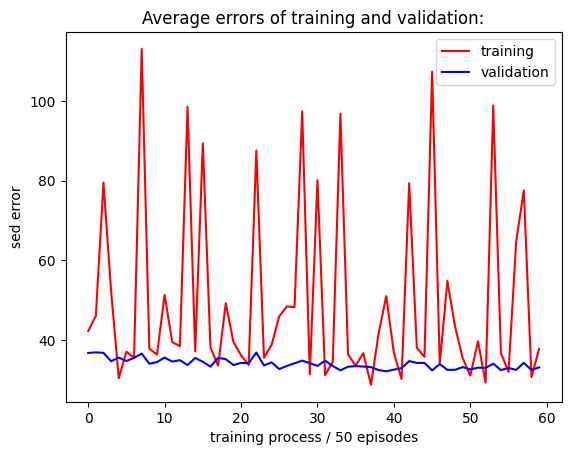

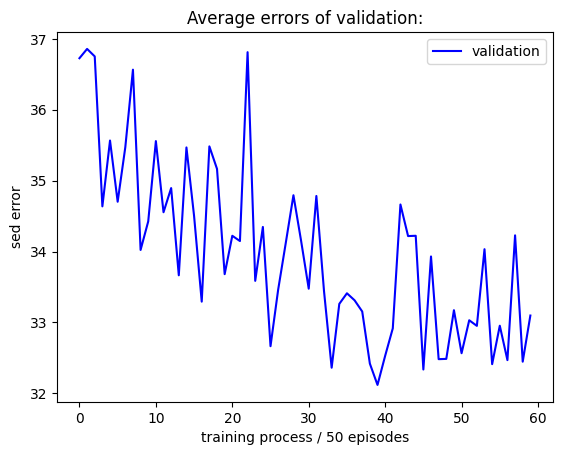

In [3]:
train(traj_amount=500, valid_amount=100, Round=6, show_time=50, ratio=0.1, a_size=3, s_size=3, learning_rate=0.001, label='sed')

======loading train data======
cut= 1000
It cost 56.948720932006836s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


round 0 episode 50: Training error: 1.4267168454483428, Validation error: 1.7264973364406606

Save model with error 1.7264973364406606
==>current best model is 1.7264973364406606 with ratio 0.1
It costs 169.18620109558105s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 0 episode 100: Training error: 1.863941642604984, Validation error: 1.6920865317161917
Save model with error 1.6920865317161917
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 169.3949375152588s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


round 0 episode 150: Training error: 1.8802419805287098, Validation error: 1.7140556678970669
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 179.5759379863739s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 0 episode 200: Training error: 1.3275004732678704, Validation error: 1.721869692498555
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 174.09709548950195s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 0 episode 250: Training error: 1.7915865402276514, Validation error: 1.721498346758836
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 171.0162537097931s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 0 episode 300: Training error: 1.7990093704082923, Validation error: 1.7239571036290096
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 178.12515807151794s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 0 episode 350: Training error: 1.8553376241319888, Validation error: 1.7278152446011288
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 172.19689440727234s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 0 episode 400: Training error: 1.5372695512019667, Validation error: 1.7122950028915074
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 169.84356117248535s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 0 episode 450: Training error: 1.6538744860067718, Validation error: 1.7440456565516405
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 169.54537224769592s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 0 episode 500: Training error: 1.8089629510145113, Validation error: 1.7046118004331168
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 169.6457793712616s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 1 episode 50: Training error: 1.6571377904961269, Validation error: 1.7202013068260495
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 168.8176920413971s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 1 episode 100: Training error: 1.741189151666519, Validation error: 1.7062153275051255
==>current best model is 1.6920865317161917 with ratio 0.1
It costs 170.25013995170593s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 1 episode 150: Training error: 1.6810475103253264, Validation error: 1.6905619292599636
Save model with error 1.6905619292599636
==>current best model is 1.6905619292599636 with ratio 0.1
It costs 175.88832902908325s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


round 1 episode 200: Training error: 1.4800122168346206, Validation error: 1.7294117316971065
==>current best model is 1.6905619292599636 with ratio 0.1
It costs 176.34818410873413s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 1 episode 250: Training error: 1.594949170352732, Validation error: 1.6881922445101893
Save model with error 1.6881922445101893
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 177.98283219337463s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 1 episode 300: Training error: 1.831613566392151, Validation error: 1.7269420569367613
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.1049509048462s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 1 episode 350: Training error: 1.7799023491353523, Validation error: 1.7083680557437753
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.55399465560913s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 1 episode 400: Training error: 1.7020627510901267, Validation error: 1.7294370970516717
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.26034665107727s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 1 episode 450: Training error: 1.8869008347026792, Validation error: 1.712704585706482
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 176.2590537071228s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 1 episode 500: Training error: 1.5579992092338038, Validation error: 1.7049829614982608
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.73908877372742s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 2 episode 50: Training error: 1.7231669387638846, Validation error: 1.707872671591019
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.62923455238342s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 2 episode 100: Training error: 1.6347591318244157, Validation error: 1.7162962589858806
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 177.15841794013977s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 2 episode 150: Training error: 1.765530660996654, Validation error: 1.7437849353368504
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.71276593208313s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 2 episode 200: Training error: 1.6227822732039465, Validation error: 1.7342165633937705
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.63055396080017s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 2 episode 250: Training error: 1.764435048929016, Validation error: 1.7133506061849513
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 177.43679857254028s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 2 episode 300: Training error: 1.9232634924961287, Validation error: 1.7000647083726201
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.51273465156555s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 2 episode 350: Training error: 1.7820256045088485, Validation error: 1.7198230595552144
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 178.56707978248596s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 2 episode 400: Training error: 1.449347419479664, Validation error: 1.743222331833411
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.0123257637024s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 2 episode 450: Training error: 1.6651007055479112, Validation error: 1.7362531236397618
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 177.68127155303955s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 2 episode 500: Training error: 1.6744521314204952, Validation error: 1.7307214826920108
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 180.83783769607544s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 3 episode 50: Training error: 1.535340022592278, Validation error: 1.7133305880631275
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.52844285964966s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 3 episode 100: Training error: 1.5413615654895267, Validation error: 1.7242557830845837
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.39761090278625s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 3 episode 150: Training error: 1.596283258484598, Validation error: 1.729595300499397
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.90268635749817s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 3 episode 200: Training error: 1.9061440541205075, Validation error: 1.7482133985257047
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.00790286064148s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 3 episode 250: Training error: 1.5706763468632703, Validation error: 1.7184298321163474
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 179.46654653549194s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 3 episode 300: Training error: 1.830437662843525, Validation error: 1.6931987644771014
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 173.81127166748047s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


round 3 episode 350: Training error: 1.546116027086365, Validation error: 1.7389145606414627
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 174.3596911430359s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 3 episode 400: Training error: 1.9464706089558452, Validation error: 1.7335130749477545
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 174.8634810447693s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 3 episode 450: Training error: 1.8384526104921337, Validation error: 1.7197365608557305
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 174.23859310150146s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 3 episode 500: Training error: 1.6235416158777278, Validation error: 1.7032043923891143
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.31900644302368s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 4 episode 50: Training error: 1.717704383964585, Validation error: 1.7099980412713003
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.60647702217102s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/it]


round 4 episode 100: Training error: 1.6519537892166638, Validation error: 1.7262264626228963
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 179.4878351688385s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 4 episode 150: Training error: 1.812078287447126, Validation error: 1.713644581419225
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 172.9531750679016s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 4 episode 200: Training error: 1.695073724279019, Validation error: 1.710931133433589
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 173.60148310661316s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 4 episode 250: Training error: 1.7909505225628388, Validation error: 1.7099905913739197
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 176.7625241279602s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 4 episode 300: Training error: 1.6970404894769109, Validation error: 1.733224899990372
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 176.0740315914154s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


round 4 episode 350: Training error: 1.7670230409276493, Validation error: 1.7073035199687845
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 176.61564826965332s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 4 episode 400: Training error: 1.8326817058341731, Validation error: 1.7403145831578168
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 176.06771779060364s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 4 episode 450: Training error: 1.5538594870622842, Validation error: 1.723663419258218
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 176.1982078552246s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 4 episode 500: Training error: 1.4370552791185731, Validation error: 1.6909107956691154
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.76263737678528s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 5 episode 50: Training error: 1.4125496524960062, Validation error: 1.7327060058004593
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 173.12115693092346s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 5 episode 100: Training error: 1.8007435590721128, Validation error: 1.705738845242149
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 179.02617168426514s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 5 episode 150: Training error: 1.8531675186652956, Validation error: 1.7144133517531037
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.82488632202148s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 5 episode 200: Training error: 1.8255890567339395, Validation error: 1.712605951074922
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 174.71384596824646s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 5 episode 250: Training error: 1.5893347107423446, Validation error: 1.6977778076488297
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 174.00618314743042s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.29s/it]


round 5 episode 300: Training error: 1.7744731449743827, Validation error: 1.7264982779033842
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 179.82204627990723s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 5 episode 350: Training error: 1.4754286532992236, Validation error: 1.7143812706669492
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.67913675308228s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


round 5 episode 400: Training error: 1.6693409052347548, Validation error: 1.7198977604428578
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 171.07690119743347s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 5 episode 450: Training error: 1.926837585722317, Validation error: 1.733588645151536
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 171.63932919502258s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


round 5 episode 500: Training error: 1.7903818066052088, Validation error: 1.7186358800899573
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 172.17916655540466s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


round 6 episode 50: Training error: 1.6969714972505365, Validation error: 1.7592910932819237
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 172.45085906982422s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 6 episode 100: Training error: 1.8115704809676305, Validation error: 1.7009438655898128
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 174.55005979537964s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 6 episode 150: Training error: 1.8838993277494132, Validation error: 1.70695934374728
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.84252214431763s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 6 episode 200: Training error: 1.9724589880123378, Validation error: 1.7260221793510546
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 170.35873174667358s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


round 6 episode 250: Training error: 1.4907824290617966, Validation error: 1.7143164876400883
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 173.57401704788208s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 6 episode 300: Training error: 1.849945247895444, Validation error: 1.7019009059033607
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 171.78186082839966s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


round 6 episode 350: Training error: 1.6141283640673618, Validation error: 1.7095819269598236
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 171.92923092842102s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 6 episode 400: Training error: 1.5142504190052872, Validation error: 1.7016822622997894
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 176.03474354743958s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 6 episode 450: Training error: 1.4087930246277398, Validation error: 1.697772440013817
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 176.206885099411s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 6 episode 500: Training error: 1.7049095505679113, Validation error: 1.7237141203144644
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 181.58876943588257s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 7 episode 50: Training error: 1.8038181386537646, Validation error: 1.6996887262668647
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 178.47059869766235s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/it]


round 7 episode 100: Training error: 1.8945220437246955, Validation error: 1.7230700844797016
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 177.24633121490479s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 7 episode 150: Training error: 2.015795263454102, Validation error: 1.7015310263295365
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 172.50651025772095s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 7 episode 200: Training error: 1.5732048663015903, Validation error: 1.7237024373438623
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 168.9154019355774s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 7 episode 250: Training error: 1.7696079979480992, Validation error: 1.7169828353798224
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 171.00357913970947s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 7 episode 300: Training error: 1.66057427749518, Validation error: 1.7341657165053395
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 172.88160753250122s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 7 episode 350: Training error: 1.6239609419425693, Validation error: 1.7246219614448908
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 168.8757839202881s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


round 7 episode 400: Training error: 1.447604751974597, Validation error: 1.7100133142903655
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 168.16150426864624s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 7 episode 450: Training error: 1.6666254146509878, Validation error: 1.7093347762905073
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 167.88561296463013s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 7 episode 500: Training error: 1.439348334960136, Validation error: 1.7122226933860085
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 168.34673261642456s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 8 episode 50: Training error: 1.7028570069470776, Validation error: 1.7266974498502996
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 167.9819300174713s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 8 episode 100: Training error: 1.6855227898189384, Validation error: 1.6990540121995448
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 168.7678062915802s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 8 episode 150: Training error: 1.8769553869369142, Validation error: 1.715745229424289
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 167.9367277622223s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 8 episode 200: Training error: 1.6201477061019733, Validation error: 1.7257048429899187
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 169.38299202919006s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 8 episode 250: Training error: 1.636670548933037, Validation error: 1.7114993285081976
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 169.10596799850464s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.14s/it]


round 8 episode 300: Training error: 2.044581494156793, Validation error: 1.7049518171468945
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 167.78750491142273s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 8 episode 350: Training error: 1.5539745928379483, Validation error: 1.711353582335711
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 169.5872724056244s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 8 episode 400: Training error: 1.4739170079558752, Validation error: 1.7310486047536613
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 168.5186264514923s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 8 episode 450: Training error: 1.5810602463435626, Validation error: 1.715564752402077
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 168.13888430595398s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 8 episode 500: Training error: 1.7773434989284846, Validation error: 1.722295798984304
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 181.80638194084167s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


round 9 episode 50: Training error: 1.7179946117676663, Validation error: 1.6998243326269362
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 173.13226413726807s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 9 episode 100: Training error: 1.464965828876941, Validation error: 1.715615151357194
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.3668351173401s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


round 9 episode 150: Training error: 1.634288061223009, Validation error: 1.6993882023881282
==>current best model is 1.6881922445101893 with ratio 0.1
It costs 175.45892214775085s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 9 episode 200: Training error: 1.645309661231, Validation error: 1.6836322845945073
Save model with error 1.6836322845945073
==>current best model is 1.6836322845945073 with ratio 0.1
It costs 176.41505646705627s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 9 episode 250: Training error: 1.631462734737677, Validation error: 1.719628093906089
==>current best model is 1.6836322845945073 with ratio 0.1
It costs 175.98031163215637s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 9 episode 300: Training error: 1.8756085406905718, Validation error: 1.6818376374509187
Save model with error 1.6818376374509187
==>current best model is 1.6818376374509187 with ratio 0.1
It costs 175.37840270996094s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 9 episode 350: Training error: 1.3734403094865342, Validation error: 1.7114713763358904
==>current best model is 1.6818376374509187 with ratio 0.1
It costs 179.97343564033508s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 9 episode 400: Training error: 1.6858919123644611, Validation error: 1.7251716473461571
==>current best model is 1.6818376374509187 with ratio 0.1
It costs 175.32058906555176s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


round 9 episode 450: Training error: 2.0196319645301504, Validation error: 1.7265921765044245
==>current best model is 1.6818376374509187 with ratio 0.1
It costs 175.5652720928192s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


round 9 episode 500: Training error: 1.876521121828169, Validation error: 1.7164999252268098
==>current best model is 1.6818376374509187 with ratio 0.1
It costs 176.05443668365479s
Training elapsed time = %s 17415.403432130814


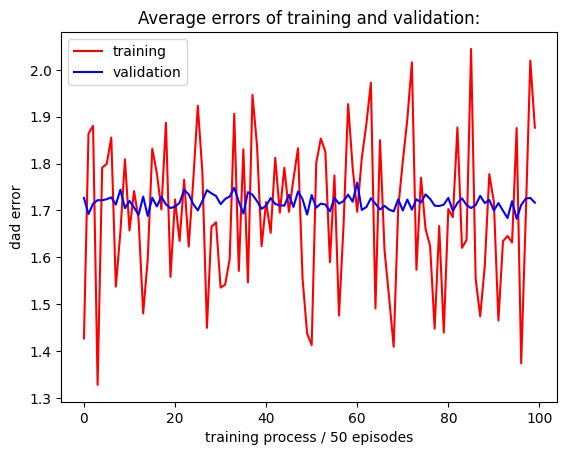

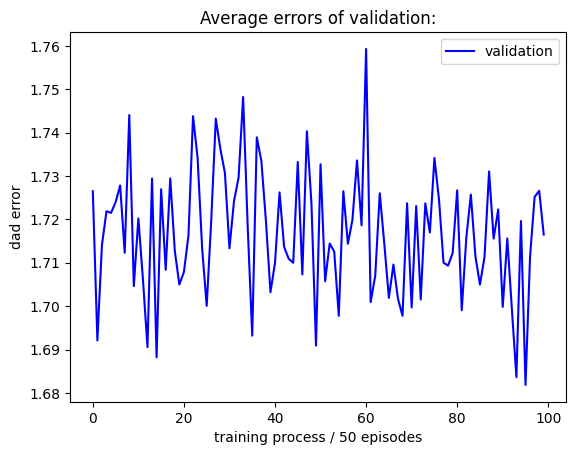

In [3]:
train(traj_amount=500, valid_amount=100, Round=10, show_time=50, ratio=0.1, a_size=3, s_size=3, learning_rate=0.001, label='dad')

======loading train data======
cut= 1000
It cost 38.4241259098053s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.37it/s]


round 0 episode 50: Training error: 8.358453833726461, Validation error: 17.548688379216344

Save model with error 17.548688379216344
==>current best model is 17.548688379216344 with ratio 0.1
It costs 261.41405177116394s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 0 episode 100: Training error: 23.052837946626717, Validation error: 18.572596918486294
==>current best model is 17.548688379216344 with ratio 0.1
It costs 283.8297803401947s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


round 0 episode 150: Training error: 27.476078941868554, Validation error: 19.869746897001065
==>current best model is 17.548688379216344 with ratio 0.1
It costs 284.1114411354065s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 0 episode 200: Training error: 25.118960037902795, Validation error: 18.146467988021868
==>current best model is 17.548688379216344 with ratio 0.1
It costs 282.8507385253906s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 0 episode 250: Training error: 21.67300178996566, Validation error: 18.666362973732532
==>current best model is 17.548688379216344 with ratio 0.1
It costs 281.56566977500916s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 0 episode 300: Training error: 18.761969597309957, Validation error: 18.007366582938133
==>current best model is 17.548688379216344 with ratio 0.1
It costs 281.6589026451111s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 0 episode 350: Training error: 18.80392661758137, Validation error: 19.33859463507956
==>current best model is 17.548688379216344 with ratio 0.1
It costs 281.75062441825867s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


round 0 episode 400: Training error: 19.63050303942419, Validation error: 17.76199875902855
==>current best model is 17.548688379216344 with ratio 0.1
It costs 282.8849127292633s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


round 0 episode 450: Training error: 17.555198764808786, Validation error: 17.60257601649336
==>current best model is 17.548688379216344 with ratio 0.1
It costs 285.85687613487244s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 0 episode 500: Training error: 17.82692169622639, Validation error: 16.86265686568482
Save model with error 16.86265686568482
==>current best model is 16.86265686568482 with ratio 0.1
It costs 282.98946237564087s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


round 1 episode 50: Training error: 17.492529848147903, Validation error: 17.610133377956025
==>current best model is 16.86265686568482 with ratio 0.1
It costs 286.2955017089844s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 1 episode 100: Training error: 14.801493786014216, Validation error: 16.61838236392927
Save model with error 16.61838236392927
==>current best model is 16.61838236392927 with ratio 0.1
It costs 283.5814423561096s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 1 episode 150: Training error: 12.122388008352017, Validation error: 17.810278236738583
==>current best model is 16.61838236392927 with ratio 0.1
It costs 281.37219738960266s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 1 episode 200: Training error: 10.706582328670509, Validation error: 16.49623606432916
Save model with error 16.49623606432916
==>current best model is 16.49623606432916 with ratio 0.1
It costs 281.9007966518402s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 1 episode 250: Training error: 10.416205363949407, Validation error: 17.15339497996233
==>current best model is 16.49623606432916 with ratio 0.1
It costs 285.99544501304626s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 1 episode 300: Training error: 10.929054084319967, Validation error: 16.379438781578195
Save model with error 16.379438781578195
==>current best model is 16.379438781578195 with ratio 0.1
It costs 284.53698682785034s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 1 episode 350: Training error: 10.388527713071536, Validation error: 17.64745020384545
==>current best model is 16.379438781578195 with ratio 0.1
It costs 285.01798462867737s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/it]


round 1 episode 400: Training error: 8.211352212272836, Validation error: 17.71691400079837
==>current best model is 16.379438781578195 with ratio 0.1
It costs 286.68007826805115s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 1 episode 450: Training error: 9.900778198348503, Validation error: 16.35068927376934
Save model with error 16.35068927376934
==>current best model is 16.35068927376934 with ratio 0.1
It costs 282.07243275642395s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 1 episode 500: Training error: 9.154755709897358, Validation error: 17.42701632620983
==>current best model is 16.35068927376934 with ratio 0.1
It costs 281.12317872047424s
Training elapsed time = %s 5647.489614009857


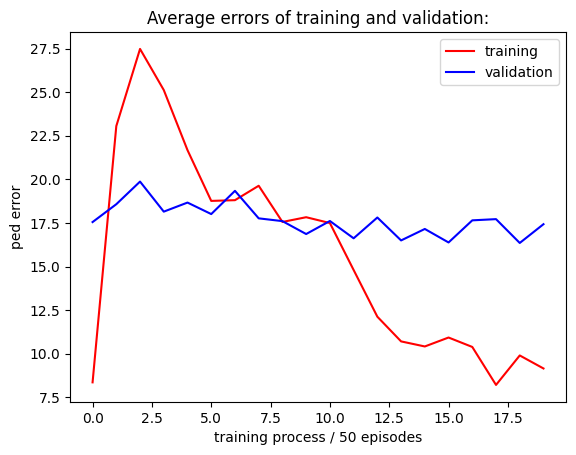

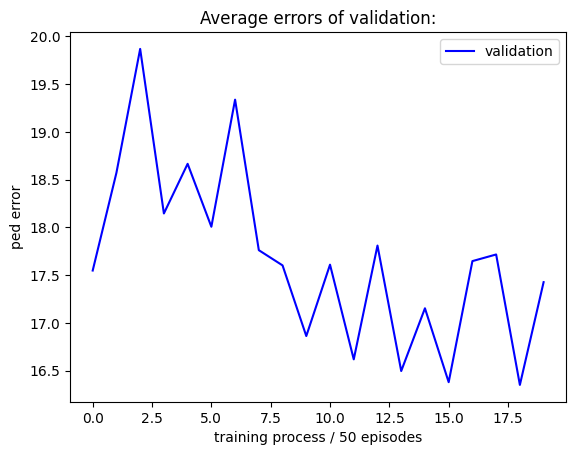

In [3]:
train(traj_amount=500, valid_amount=100, Round=2, show_time=50, ratio=0.1, a_size=3, s_size=3, learning_rate=0.001, label='ped')

======loading train data======
cut= 1000
It cost 38.91797614097595s.


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


round 0 episode 50: Training error: 17.168992658528293, Validation error: 16.971122119025825
Save model with error 16.971122119025825
==>current best model is 16.971122119025825 with ratio 0.1
It costs 286.4030694961548s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 0 episode 100: Training error: 22.165275104157466, Validation error: 16.672024728411976
Save model with error 16.672024728411976
==>current best model is 16.672024728411976 with ratio 0.1
It costs 284.57437348365784s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.16s/it]


round 0 episode 150: Training error: 365.8328352040841, Validation error: 18.536549955290013
==>current best model is 16.672024728411976 with ratio 0.1
It costs 283.67527413368225s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


round 0 episode 200: Training error: 275.4325466266947, Validation error: 19.540184860526978
==>current best model is 16.672024728411976 with ratio 0.1
It costs 280.75803995132446s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


round 0 episode 250: Training error: 221.88959704910081, Validation error: 16.80055444378447
==>current best model is 16.672024728411976 with ratio 0.1
It costs 287.5732765197754s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 0 episode 300: Training error: 186.5653628080911, Validation error: 16.75179951312845
==>current best model is 16.672024728411976 with ratio 0.1
It costs 230.17224717140198s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 0 episode 350: Training error: 160.12082948771598, Validation error: 15.097621370441622
Save model with error 15.097621370441622
==>current best model is 15.097621370441622 with ratio 0.1
It costs 231.48364901542664s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 0 episode 400: Training error: 141.0254749789651, Validation error: 16.98871731387009
==>current best model is 15.097621370441622 with ratio 0.1
It costs 234.55065274238586s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 0 episode 450: Training error: 127.33721271966225, Validation error: 16.79389511461225
==>current best model is 15.097621370441622 with ratio 0.1
It costs 233.559415102005s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 0 episode 500: Training error: 115.3304059421793, Validation error: 16.239181805433574
==>current best model is 15.097621370441622 with ratio 0.1
It costs 234.13366317749023s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 1 episode 50: Training error: 115.29482510189612, Validation error: 15.304273896094614
==>current best model is 15.097621370441622 with ratio 0.1
It costs 233.77003955841064s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 1 episode 100: Training error: 112.9072551185313, Validation error: 16.863320819568234
==>current best model is 15.097621370441622 with ratio 0.1
It costs 235.38376641273499s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 1 episode 150: Training error: 9.44741569468599, Validation error: 16.526373779211667
==>current best model is 15.097621370441622 with ratio 0.1
It costs 233.6754801273346s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 1 episode 200: Training error: 10.063713811013065, Validation error: 19.762879206830036
==>current best model is 15.097621370441622 with ratio 0.1
It costs 237.39442348480225s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 1 episode 250: Training error: 9.960127029530332, Validation error: 15.604780257073388
==>current best model is 15.097621370441622 with ratio 0.1
It costs 234.322603225708s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 1 episode 300: Training error: 9.956784750049673, Validation error: 15.861606874263199
==>current best model is 15.097621370441622 with ratio 0.1
It costs 233.17858910560608s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 1 episode 350: Training error: 10.560187915970278, Validation error: 16.010833727919355
==>current best model is 15.097621370441622 with ratio 0.1
It costs 232.0228443145752s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 1 episode 400: Training error: 10.454912545233991, Validation error: 16.856908193780246
==>current best model is 15.097621370441622 with ratio 0.1
It costs 233.1230661869049s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 1 episode 450: Training error: 9.567909058863899, Validation error: 15.738279478344932
==>current best model is 15.097621370441622 with ratio 0.1
It costs 231.79363346099854s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 1 episode 500: Training error: 9.469650686788837, Validation error: 15.546654617554971
==>current best model is 15.097621370441622 with ratio 0.1
It costs 232.58775782585144s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 2 episode 50: Training error: 11.625436165395254, Validation error: 16.62716041438022
==>current best model is 15.097621370441622 with ratio 0.1
It costs 231.99948859214783s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 2 episode 100: Training error: 11.98582768282892, Validation error: 14.600459344559923
Save model with error 14.600459344559923
==>current best model is 14.600459344559923 with ratio 0.1
It costs 234.32329201698303s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 2 episode 150: Training error: 10.638322300467777, Validation error: 15.873457620715483
==>current best model is 14.600459344559923 with ratio 0.1
It costs 231.47481155395508s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 2 episode 200: Training error: 10.512300009301752, Validation error: 15.231915254203805
==>current best model is 14.600459344559923 with ratio 0.1
It costs 232.4646918773651s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 2 episode 250: Training error: 12.175627520444252, Validation error: 16.417747527924625
==>current best model is 14.600459344559923 with ratio 0.1
It costs 230.87197303771973s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 2 episode 300: Training error: 11.48801862044322, Validation error: 14.751933982782974
==>current best model is 14.600459344559923 with ratio 0.1
It costs 232.3636600971222s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 2 episode 350: Training error: 12.22213332632614, Validation error: 15.53018381216933
==>current best model is 14.600459344559923 with ratio 0.1
It costs 232.07167720794678s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 2 episode 400: Training error: 12.534842569919244, Validation error: 15.560633235429014
==>current best model is 14.600459344559923 with ratio 0.1
It costs 231.36110258102417s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 2 episode 450: Training error: 15.234107119477176, Validation error: 19.2297990892671
==>current best model is 14.600459344559923 with ratio 0.1
It costs 231.78971982002258s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


round 2 episode 500: Training error: 15.745961538637882, Validation error: 17.115042674246986
==>current best model is 14.600459344559923 with ratio 0.1
It costs 236.57346510887146s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 3 episode 50: Training error: 12.79619529320254, Validation error: 14.903731302758775
==>current best model is 14.600459344559923 with ratio 0.1
It costs 231.08131456375122s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 3 episode 100: Training error: 12.832180546239949, Validation error: 16.080920020165394
==>current best model is 14.600459344559923 with ratio 0.1
It costs 226.61353993415833s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 3 episode 150: Training error: 13.26674047900807, Validation error: 19.549765820236765
==>current best model is 14.600459344559923 with ratio 0.1
It costs 230.71282625198364s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 3 episode 200: Training error: 13.21548582331827, Validation error: 17.29494707248487
==>current best model is 14.600459344559923 with ratio 0.1
It costs 231.96022629737854s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 3 episode 250: Training error: 11.572729656229523, Validation error: 17.49760284989249
==>current best model is 14.600459344559923 with ratio 0.1
It costs 232.6803104877472s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 3 episode 300: Training error: 12.654634258782545, Validation error: 15.326326122970936
==>current best model is 14.600459344559923 with ratio 0.1
It costs 231.134783744812s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 3 episode 350: Training error: 18.333473334620766, Validation error: 16.64461153259549
==>current best model is 14.600459344559923 with ratio 0.1
It costs 230.97975754737854s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 3 episode 400: Training error: 17.89493831240053, Validation error: 15.886804059689982
==>current best model is 14.600459344559923 with ratio 0.1
It costs 231.59181785583496s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 3 episode 450: Training error: 15.653518553640982, Validation error: 17.673730714570528
==>current best model is 14.600459344559923 with ratio 0.1
It costs 233.82729268074036s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 3 episode 500: Training error: 15.922051204290915, Validation error: 17.308468921329276
==>current best model is 14.600459344559923 with ratio 0.1
It costs 232.21992230415344s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 4 episode 50: Training error: 15.942818678998588, Validation error: 15.26842982791472
==>current best model is 14.600459344559923 with ratio 0.1
It costs 231.18763709068298s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 4 episode 100: Training error: 15.909402497636373, Validation error: 15.76919480061277
==>current best model is 14.600459344559923 with ratio 0.1
It costs 230.61373949050903s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 4 episode 150: Training error: 15.427078869972286, Validation error: 16.354437821329586
==>current best model is 14.600459344559923 with ratio 0.1
It costs 230.3231906890869s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 4 episode 200: Training error: 16.859040801822545, Validation error: 17.488449761278257
==>current best model is 14.600459344559923 with ratio 0.1
It costs 231.1433093547821s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


round 4 episode 250: Training error: 16.49971922049553, Validation error: 17.341223171341127
==>current best model is 14.600459344559923 with ratio 0.1
It costs 235.1421127319336s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


round 4 episode 300: Training error: 16.31296916553935, Validation error: 14.43303735379369
Save model with error 14.43303735379369
==>current best model is 14.43303735379369 with ratio 0.1
It costs 231.43141555786133s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 4 episode 350: Training error: 10.566746177197313, Validation error: 15.896565699840515
==>current best model is 14.43303735379369 with ratio 0.1
It costs 234.01626133918762s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


round 4 episode 400: Training error: 13.649931591170027, Validation error: 17.494697001617475
==>current best model is 14.43303735379369 with ratio 0.1
It costs 233.09526300430298s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 4 episode 450: Training error: 15.3835843557114, Validation error: 16.61571206345355
==>current best model is 14.43303735379369 with ratio 0.1
It costs 234.39484810829163s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 4 episode 500: Training error: 14.168313372071243, Validation error: 16.712211258722522
==>current best model is 14.43303735379369 with ratio 0.1
It costs 234.21674728393555s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 5 episode 50: Training error: 14.560279295646463, Validation error: 15.145875427822022
==>current best model is 14.43303735379369 with ratio 0.1
It costs 238.58866620063782s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 5 episode 100: Training error: 15.7316139144109, Validation error: 16.327350884009697
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.87909054756165s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 5 episode 150: Training error: 16.66250861113343, Validation error: 14.849988995705178
==>current best model is 14.43303735379369 with ratio 0.1
It costs 237.30538201332092s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 5 episode 200: Training error: 15.850071434246766, Validation error: 16.287723147726446
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.19850087165833s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 5 episode 250: Training error: 16.95901590885387, Validation error: 15.79765789422749
==>current best model is 14.43303735379369 with ratio 0.1
It costs 237.05612659454346s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 5 episode 300: Training error: 16.651577637348478, Validation error: 15.965107265184956
==>current best model is 14.43303735379369 with ratio 0.1
It costs 237.2905876636505s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 5 episode 350: Training error: 18.063139872032046, Validation error: 16.480451414547645
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.31839275360107s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


round 5 episode 400: Training error: 15.385372782726407, Validation error: 16.89345568572466
==>current best model is 14.43303735379369 with ratio 0.1
It costs 238.03585648536682s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 5 episode 450: Training error: 12.512446370123216, Validation error: 17.007278609062723
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.54902982711792s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 5 episode 500: Training error: 14.490172981100224, Validation error: 16.270205678343373
==>current best model is 14.43303735379369 with ratio 0.1
It costs 237.29432010650635s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


round 6 episode 50: Training error: 22.051198385564128, Validation error: 16.422432613222867
==>current best model is 14.43303735379369 with ratio 0.1
It costs 238.24335741996765s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 6 episode 100: Training error: 20.91768996854517, Validation error: 16.928809713548784
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.9153938293457s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 6 episode 150: Training error: 22.331807005155273, Validation error: 16.856188377678322
==>current best model is 14.43303735379369 with ratio 0.1
It costs 237.264244556427s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 6 episode 200: Training error: 21.365360887906935, Validation error: 19.175195171993714
==>current best model is 14.43303735379369 with ratio 0.1
It costs 237.70708584785461s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 6 episode 250: Training error: 20.988320514946828, Validation error: 20.882752642296722
==>current best model is 14.43303735379369 with ratio 0.1
It costs 237.6185007095337s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 6 episode 300: Training error: 22.553691501528572, Validation error: 21.027941095769137
==>current best model is 14.43303735379369 with ratio 0.1
It costs 248.00887274742126s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 6 episode 350: Training error: 20.077861868848007, Validation error: 17.538089529016332
==>current best model is 14.43303735379369 with ratio 0.1
It costs 237.26733255386353s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 6 episode 400: Training error: 19.592397022164327, Validation error: 14.988669734721551
==>current best model is 14.43303735379369 with ratio 0.1
It costs 239.02272534370422s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 6 episode 450: Training error: 20.259156324297116, Validation error: 15.324586716753023
==>current best model is 14.43303735379369 with ratio 0.1
It costs 237.76921319961548s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


round 6 episode 500: Training error: 18.92049828687696, Validation error: 16.796776659896718
==>current best model is 14.43303735379369 with ratio 0.1
It costs 285.89412236213684s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


round 7 episode 50: Training error: 11.090797201790613, Validation error: 15.893742862063501
==>current best model is 14.43303735379369 with ratio 0.1
It costs 263.7209758758545s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 7 episode 100: Training error: 10.847103802431151, Validation error: 15.903221466257744
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.10148406028748s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 7 episode 150: Training error: 10.134989547644098, Validation error: 15.80565829472147
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.71580815315247s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 7 episode 200: Training error: 12.086044664211034, Validation error: 16.458514022382737
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.33577346801758s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 7 episode 250: Training error: 11.405462102364929, Validation error: 15.373357123097946
==>current best model is 14.43303735379369 with ratio 0.1
It costs 241.9916889667511s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 7 episode 300: Training error: 9.74927201840039, Validation error: 16.449641260174236
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.29119682312012s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


round 7 episode 350: Training error: 11.340892160494695, Validation error: 16.345254581984687
==>current best model is 14.43303735379369 with ratio 0.1
It costs 235.68472456932068s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 7 episode 400: Training error: 11.792714527729833, Validation error: 14.703277501752908
==>current best model is 14.43303735379369 with ratio 0.1
It costs 235.38718485832214s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 7 episode 450: Training error: 14.524546931098353, Validation error: 15.853034375507566
==>current best model is 14.43303735379369 with ratio 0.1
It costs 236.87931752204895s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 7 episode 500: Training error: 14.390174909887477, Validation error: 14.31836325906109
Save model with error 14.31836325906109
==>current best model is 14.31836325906109 with ratio 0.1
It costs 236.9324028491974s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 8 episode 50: Training error: 14.455379011739467, Validation error: 15.919581624089929
==>current best model is 14.31836325906109 with ratio 0.1
It costs 237.1673390865326s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 8 episode 100: Training error: 15.29267789461205, Validation error: 14.666314010958011
==>current best model is 14.31836325906109 with ratio 0.1
It costs 238.0468270778656s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 8 episode 150: Training error: 14.580918368536095, Validation error: 16.15159416099314
==>current best model is 14.31836325906109 with ratio 0.1
It costs 238.25802731513977s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 8 episode 200: Training error: 12.887162459211549, Validation error: 16.12606192410048
==>current best model is 14.31836325906109 with ratio 0.1
It costs 236.26297235488892s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 8 episode 250: Training error: 13.291534925475897, Validation error: 15.708722745800415
==>current best model is 14.31836325906109 with ratio 0.1
It costs 237.85503697395325s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 8 episode 300: Training error: 17.04935066679395, Validation error: 15.064747938583917
==>current best model is 14.31836325906109 with ratio 0.1
It costs 236.15961909294128s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 8 episode 350: Training error: 15.926309475728056, Validation error: 16.690572702140066
==>current best model is 14.31836325906109 with ratio 0.1
It costs 239.46306896209717s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 8 episode 400: Training error: 15.180492845350859, Validation error: 15.114189821769628
==>current best model is 14.31836325906109 with ratio 0.1
It costs 235.85999512672424s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 8 episode 450: Training error: 29.298844059505388, Validation error: 15.416718973647626
==>current best model is 14.31836325906109 with ratio 0.1
It costs 241.50631713867188s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 8 episode 500: Training error: 29.490746665600096, Validation error: 15.864134449630741
==>current best model is 14.31836325906109 with ratio 0.1
It costs 237.01168870925903s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 9 episode 50: Training error: 29.30805189633811, Validation error: 16.284597705593008
==>current best model is 14.31836325906109 with ratio 0.1
It costs 236.79506635665894s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 9 episode 100: Training error: 28.54770629594349, Validation error: 14.354688578376223
==>current best model is 14.31836325906109 with ratio 0.1
It costs 236.08072972297668s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 9 episode 150: Training error: 28.971985255742815, Validation error: 16.135103038774258
==>current best model is 14.31836325906109 with ratio 0.1
It costs 237.0964858531952s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


round 9 episode 200: Training error: 33.1024777641894, Validation error: 17.79661474079299
==>current best model is 14.31836325906109 with ratio 0.1
It costs 237.89244985580444s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 9 episode 250: Training error: 50.32203824301091, Validation error: 17.87648722734756
==>current best model is 14.31836325906109 with ratio 0.1
It costs 237.68050074577332s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 9 episode 300: Training error: 46.66123982128947, Validation error: 19.817107167044842
==>current best model is 14.31836325906109 with ratio 0.1
It costs 238.0166299343109s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 9 episode 350: Training error: 48.982880422712796, Validation error: 20.622091806132016
==>current best model is 14.31836325906109 with ratio 0.1
It costs 238.6352744102478s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 9 episode 400: Training error: 50.6593386699213, Validation error: 19.866318841296234
==>current best model is 14.31836325906109 with ratio 0.1
It costs 240.94240403175354s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


round 9 episode 450: Training error: 33.581978224406356, Validation error: 18.464915237132104
==>current best model is 14.31836325906109 with ratio 0.1
It costs 238.51310086250305s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


round 9 episode 500: Training error: 33.221869042728436, Validation error: 20.594007161856542
==>current best model is 14.31836325906109 with ratio 0.1
It costs 238.22079753875732s
Training elapsed time = %s 23848.531440496445


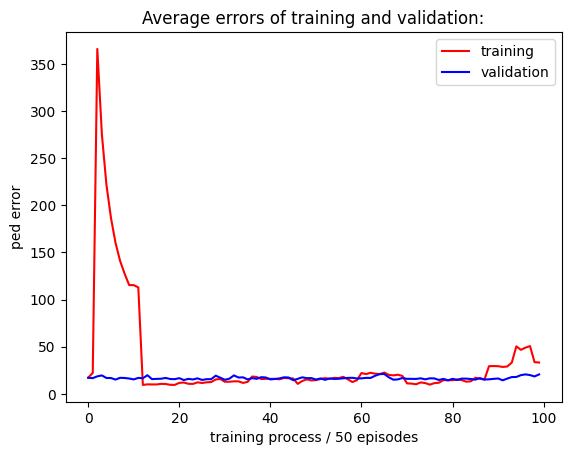

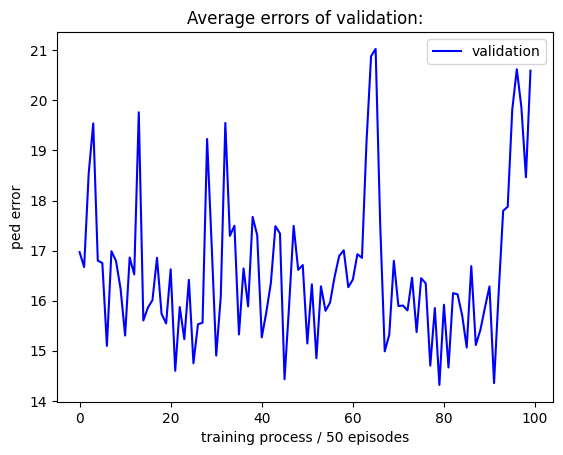

In [4]:
train(traj_amount=500, valid_amount=100, Round=10, show_time=50, ratio=0.1, a_size=3, s_size=3, learning_rate=0.005, label='ped')

# evaluate

In [8]:
from rl_env_inc import TrajComp
from rl_brain import PolicyGradient
import data_utils as F
import time

def evaluate(env, RL, ratio, elist): # Evaluation
    eva = []
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            action = RL.quick_time_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    print(len(eva))
    return sum(eva)/len(eva)

def test(model_path, amount, ratio, a_size, s_size, label):
    print("======Start testing the model at {}======".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_test_data(traj_path, amount, cut=True)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    start = time.time()
    effectiveness = evaluate(env, rl, ratio, range(amount))
    print("Effectiveness: %e" %effectiveness)
    print("Training elapsed time = %s", float(time.time() - start))
    return effectiveness    

def test_one_sample(model_path, index, ratio, a_size, s_size, label):
    print("======Start testing the model at {}======".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_one_sample(traj_path, index)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    
    net_time = 0
    step_time = 0
    start_ = time.time()
    eva = []
    buffer_size = int(ratio*len(env.ori_traj_set[0]))
    if buffer_size < 3:
        return
    steps, observation = env.reset(0, buffer_size)
    for index in range(buffer_size, steps):
        if index == steps - 1:
            done = True
        else:
            done = False
        start = time.time()
        action = rl.quick_time_action(observation)
        net_time += float(time.time()-start)
        start = time.time()
        observation_, _ = env.step(0, action, index, done, 'V') #'T' means Training, and 'V' means Validation
        step_time += float(time.time()-start)
        observation = observation_
    eva=env.output(0, 'V') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    print("Effectiveness: %e" %eva)
    print("Training elapsed time = %s", float(time.time() - start_))
    print("net_time:",net_time)
    print("step_time:",step_time)   

def evaluate_skip(elist):
    effectiveness = []
    total_len = []
    skip_pts = 0
    step_pts = 0
    for episode in elist:
        #print('online episode', episode)
        total_len.append(len(env.ori_traj_set[episode]))
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        step_pts = step_pts + steps
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            if index < env.INX:
                #print('test skip')
                skip_pts = skip_pts + 1
                continue
            action = RL.quick_time_action(observation) #matrix implementation for fast efficiency when the model is ready
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        effectiveness.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return sum(effectiveness)/len(effectiveness)


## sed

In [22]:
test(model_path='save/29.892935908168525_ratio_0.1_sed/', amount=300, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at save/29.892935908168525_ratio_0.1_sed/======
======loading test data======
It cost 3.6821675300598145s
training from last checkpoint save/29.892935908168525_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save/29.892935908168525_ratio_0.1_sed/trained_model.ckpt
300
Effectiveness: 2.910492e+01
Training elapsed time = %s 36.69314384460449


29.10492045912079